# Сборный проект — 2. «HR-аналитика»

### Описание задачи

HR-аналитики компании «Работа с заботой» помогают бизнесу оптимизировать управление персоналом: бизнес предоставляет данные, а аналитики предлагают, как избежать финансовых потерь и оттока сотрудников.
Бизнесу важна удовлетворённость сотрудников работой, т.к. это напрямую влияет на их отток из компании.
А предсказание оттока — одна из важнейших задач HR-аналитиков, поскольку внезапные увольнения несут в себе риски для компании,
особенно если уходит важный сотрудник.

#### Постановка задачи

Перед нами стоят две задачи:
* построить модель, которая сможет предсказать уровень удовлетворённости сотрудника на основе данных заказчика
* построить модель, которая сможет на основе данных заказчика предсказать то, что сотрудник уволится из компании.

### Описание данных

Данные представляют собой результаты анкетирования, в ходе которого сотрудники заполняли тест-опросник и по его результатам рассчитывается
доля их удовлетворенности от 0 до 1, где 0 — совершенно неудовлетворен, 1 — полностью удовлетворен.

Для первой задачи мы имеем три датасета:
* train_job_satisfaction_rate.csv — тренировочнвя выборка
* test_features.csv — входные признаки тестовой выборки
* test_target_job_satisfaction_rate.csv — целевой признак тестовой выборки

Для второй задачи мы также имеем три датасета:
Для этой задачи можно использовать те же входные признаки, что и в первой задаче.
Однако целевой признак отличается, теперь это — увольнение сотрудника из компании.
* train_quit.csv — тренировочная выборка
* test_features.csv — входные признаки тестовой выборки (те же, что и в прошлой задаче)
* test_target_quit.csv — целевой признак тестовой выборки

## Загрузка библиотек

In [3]:
!pip install phik

DEPRECATION: Loading egg at /usr/lib64/python3.11/site-packages/TBB-2021.12.0-py3.11-linux-x86_64.egg is deprecated. pip 24.3 will enforce this behaviour change. A possible replacement is to use pip for package installation. Discussion can be found at https://github.com/pypa/pip/issues/12330
error: externally-managed-environment

× This environment is externally managed
╰─> To install Python packages system-wide, try
    zypper install python311-xyz, where xyz is the package
    you are trying to install.
    
    If you wish to install a non-rpm packaged Python package,
    create a virtual environment using python3.11 -m venv path/to/venv.
    Then use path/to/venv/bin/python and path/to/venv/bin/pip.
    
    If you wish to install a non-rpm packaged Python application,
    it may be easiest to use `pipx install xyz`, which will manage a
    virtual environment for you. Install pipx via `zypper install python311-pipx` .

note: If you believe this is a mistake, please contact your Py

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import phik
from phik import phik_matrix
from phik.report import plot_correlation_matrix
import seaborn as sns
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, StandardScaler, MinMaxScaler, LabelEncoder
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.metrics import confusion_matrix, mean_absolute_error
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import make_scorer, roc_auc_score
from sklearn.svm import SVR

In [5]:
RANDOM_STATE = 12345

In [6]:
pd.set_option('display.max_colwidth', None)

## Предсказание уровня удовлетворенности сотрудника

### Загрузка данных

In [7]:
filename_train_job_satisfaction_rate = 'train_job_satisfaction_rate.csv'
filename_test_features = 'test_features.csv'
filename_test_target_job_satisfaction_rate = 'test_target_job_satisfaction_rate.csv'

In [8]:
try:
    data_train_job_satisfaction_rate = pd.read_csv('/datasets/' + filename_train_job_satisfaction_rate)
except:
    data_train_job_satisfaction_rate = pd.read_csv(filename_train_job_satisfaction_rate)

In [9]:
try:
    data_test_features = pd.read_csv('/datasets/' + filename_test_features)
except:
    data_test_features = pd.read_csv(filename_test_features)

In [10]:
try:
    data_test_target_job_satisfaction_rate = pd.read_csv('/datasets/' + filename_test_target_job_satisfaction_rate)
except:
    data_test_target_job_satisfaction_rate = pd.read_csv(filename_test_target_job_satisfaction_rate)

#### Осмотр данных

Посмотрим на датасеты

##### train_job_satisfaction_rate

In [11]:
data_train_job_satisfaction_rate.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 10 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   id                     4000 non-null   int64  
 1   dept                   3994 non-null   object 
 2   level                  3996 non-null   object 
 3   workload               4000 non-null   object 
 4   employment_years       4000 non-null   int64  
 5   last_year_promo        4000 non-null   object 
 6   last_year_violations   4000 non-null   object 
 7   supervisor_evaluation  4000 non-null   int64  
 8   salary                 4000 non-null   int64  
 9   job_satisfaction_rate  4000 non-null   float64
dtypes: float64(1), int64(4), object(5)
memory usage: 312.6+ KB


Видим, что датасет практически полный (буквально несколько NaN'ов).
Столбцы наименованы в соответствии со стандартным стилем.

Посмотрим на первые 5 строк.

In [12]:
data_train_job_satisfaction_rate.head()

,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,job_satisfaction_rate
0,155278,sales,junior,medium,2,no,no,1,24000,0.58
1,653870,hr,junior,high,2,no,no,5,38400,0.76
2,184592,sales,junior,low,1,no,no,2,12000,0.11
3,171431,technology,junior,low,4,no,no,2,18000,0.37
4,693419,hr,junior,medium,1,no,no,3,22800,0.20


Датасет загрузился корректно.

##### test_features

In [13]:
data_test_features.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 9 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   id                     2000 non-null   int64 
 1   dept                   1998 non-null   object
 2   level                  1999 non-null   object
 3   workload               2000 non-null   object
 4   employment_years       2000 non-null   int64 
 5   last_year_promo        2000 non-null   object
 6   last_year_violations   2000 non-null   object
 7   supervisor_evaluation  2000 non-null   int64 
 8   salary                 2000 non-null   int64 
dtypes: int64(4), object(5)
memory usage: 140.8+ KB


Данные практически полные (три NaN'а).
Названия столбцов соответствуют стандартному стилю.

Посмотрим на первые 5 строк.

In [14]:
data_test_features.head()

,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary
0,485046,marketing,junior,medium,2,no,no,5,28800
1,686555,hr,junior,medium,1,no,no,4,30000
2,467458,sales,middle,low,5,no,no,4,19200
3,418655,sales,middle,low,6,no,no,4,19200
4,789145,hr,middle,medium,5,no,no,5,40800


Датасет загружен корректно.

##### test_target_job_satisfaction_rate

In [15]:
data_test_target_job_satisfaction_rate.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 2 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   id                     2000 non-null   int64  
 1   job_satisfaction_rate  2000 non-null   float64
dtypes: float64(1), int64(1)
memory usage: 31.4 KB


Датасет полный, без NaN'ов.
Названия столбцов выдержаны в соответствии со стандартным стилем.

Посмотрим на первые 5 строк.

In [16]:
data_test_target_job_satisfaction_rate.head()

,id,job_satisfaction_rate
0,130604,0.74
1,825977,0.75
2,418490,0.60
3,555320,0.72
4,826430,0.08


Датасет загрузился корректно.

Обратим внимание, что сортировка данных в рассматриваемом нами файле с тестовым целевым признаком не совпадает с сортировкой данных в файле
с тестовыми признаками (test_features).

Отсортируем данные в рассматриваемом нами файле по столбцу «id» файла с тестовыми признаками (test_features).

In [17]:
key = pd.Series({key: value for value, key in enumerate(data_test_features['id'].unique())})

In [18]:
data_test_target_job_satisfaction_rate.sort_values(by='id', key=key.reindex, inplace=True)

In [19]:
data_test_target_job_satisfaction_rate.reset_index(inplace=True, drop=True)

In [20]:
data_test_target_job_satisfaction_rate.head()

,id,job_satisfaction_rate
0,485046,0.79
1,686555,0.72
2,467458,0.64
3,418655,0.60
4,789145,0.75


Теперь сортировка по «id» одинакова.

### Предобработка данных

##### train_job_satisfaction_rate

Еще раз взглянем на первые 5 строк данных.

In [21]:
data_train_job_satisfaction_rate.head()

,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,job_satisfaction_rate
0,155278,sales,junior,medium,2,no,no,1,24000,0.58
1,653870,hr,junior,high,2,no,no,5,38400,0.76
2,184592,sales,junior,low,1,no,no,2,12000,0.11
3,171431,technology,junior,low,4,no,no,2,18000,0.37
4,693419,hr,junior,medium,1,no,no,3,22800,0.20


Проверим уникальные значения строковых признаков на предмет наличия дубликатов и прочих аномальных значений.

In [22]:
data_train_job_satisfaction_rate['dept'].unique()

array(['sales', 'hr', 'technology', 'purchasing', 'marketing', nan],
      dtype=object)

Тут все корректно, повторов и аномальных наименований отделов нет.
Есть NaN, но мы о нем знаем из осмотра данных, обработаем его позднее в пайплайне.

In [23]:
data_train_job_satisfaction_rate['level'].unique()

array(['junior', 'middle', 'sinior', nan], dtype=object)

Тут также все хорошо, ситуация с NaN'ом аналогичная.
Поменяем значения признака 'sinior' на 'senior' — так более корректно и не будет привлекать лишнее внимание.

In [24]:
data_train_job_satisfaction_rate.loc[data_train_job_satisfaction_rate['level'] == 'sinior', 'level'] = 'senior'

Рассмотрим следующий строковый признак, «workload».

In [25]:
data_train_job_satisfaction_rate['workload'].unique()

array(['medium', 'high', 'low'], dtype=object)

Тут все корректно.

In [26]:
data_train_job_satisfaction_rate['last_year_promo'].unique()

array(['no', 'yes'], dtype=object)

In [27]:
data_train_job_satisfaction_rate['last_year_violations'].unique()

array(['no', 'yes'], dtype=object)

Здесь тоже все корректно.

Проверим также, все ли id уникальны.

In [28]:
data_train_job_satisfaction_rate['id'].duplicated().any()

np.False_

Все id уникальны.

Стапо быть, дубликатов строк быть не может (т.к. столбец полный и все значения уникальны).

##### test_features

Взглянем на первые 5 строк.

In [29]:
data_test_features.head()

,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary
0,485046,marketing,junior,medium,2,no,no,5,28800
1,686555,hr,junior,medium,1,no,no,4,30000
2,467458,sales,middle,low,5,no,no,4,19200
3,418655,sales,middle,low,6,no,no,4,19200
4,789145,hr,middle,medium,5,no,no,5,40800


Проделаем аналогичные предыдущему датасету процедуры.

In [30]:
data_test_features['dept'].unique()

array(['marketing', 'hr', 'sales', 'purchasing', 'technology', nan, ' '],
      dtype=object)

Видим второй, неявный, пропуск (пробел ' ').
Обработаем его позднее в пайплайне.

In [31]:
data_test_features['level'].unique()

array(['junior', 'middle', 'sinior', nan], dtype=object)

Видим пропуск в виде NaN (мы о нем знаем).
Аналогично предыдущему датасету изменим значение признака 'sinior' на 'senior'.

In [32]:
data_test_features.loc[data_test_features['level'] == 'sinior', 'level'] = 'senior'

In [33]:
data_test_features['workload'].unique()

array(['medium', 'low', 'high', ' '], dtype=object)

Видим такой же неявный пропуск в виде пробела ' '. Обработаем его позднее в пайплайне.

In [34]:
data_test_features['last_year_promo'].unique()

array(['no', 'yes'], dtype=object)

In [35]:
data_test_features['last_year_violations'].unique()

array(['no', 'yes'], dtype=object)

Видим пропуск в виде пробела ' '.
Обработаем на этапе пайплайна.

In [36]:
data_test_features['id'].duplicated().any()

np.False_

Все значения id уникальны.
Дубликатов строк быть не может

##### test_target_job_satisfaction_rate

Тут нет строковых данных (датасет полон).

Проверим дубликаты.

In [37]:
data_test_target_job_satisfaction_rate['id'].duplicated().any()

np.False_

Их, как видим, нет.

Предобработка данных завершена.

### Исследовательский анализ данных

##### train_job_satisfaction_rate

In [38]:
data_train_job_satisfaction_rate.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 10 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   id                     4000 non-null   int64  
 1   dept                   3994 non-null   object 
 2   level                  3996 non-null   object 
 3   workload               4000 non-null   object 
 4   employment_years       4000 non-null   int64  
 5   last_year_promo        4000 non-null   object 
 6   last_year_violations   4000 non-null   object 
 7   supervisor_evaluation  4000 non-null   int64  
 8   salary                 4000 non-null   int64  
 9   job_satisfaction_rate  4000 non-null   float64
dtypes: float64(1), int64(4), object(5)
memory usage: 312.6+ KB


Посмотрим на описательную статистику числовых признаков.

In [39]:
data_train_job_satisfaction_rate.loc[:, data_train_job_satisfaction_rate.columns != 'id'].describe()

,employment_years,supervisor_evaluation,salary,job_satisfaction_rate
count,4000.000000,4000.000000,4000.000000,4000.000000
mean,3.718500,3.476500,33926.700000,0.533995
std,2.542513,1.008812,14900.703838,0.225327
min,1.000000,1.000000,12000.000000,0.030000
25%,2.000000,3.000000,22800.000000,0.360000
50%,3.000000,4.000000,30000.000000,0.560000
75%,6.000000,4.000000,43200.000000,0.710000
max,10.000000,5.000000,98400.000000,1.000000


Видим, что данные корректны, аномалий нет.

Посмотрим на распределения признаков.

Рассмотрим признак «employment_years» (длительность работы в компании (в годах))

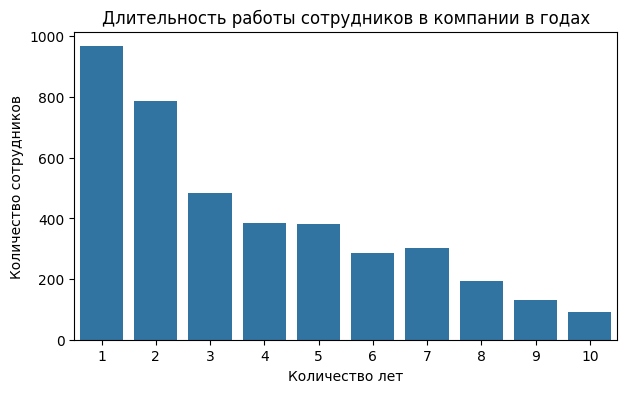

In [40]:
plt.figure(figsize=(7, 4))
sns.countplot(x = 'employment_years', data=data_train_job_satisfaction_rate)
plt.xlabel('Количество лет')
plt.ylabel('Количество сотрудников')
plt.title('Длительность работы сотрудников в компании в годах')

plt.show()

Видим, что доля сотрудников в компании, отработавших не более 2х лет, самая высокая. В целом, наблюдается убывающая картина (чем больше стаж, тем меньше сотрудников).

Посмотрим на распределение признака «supervisor_evaluation» (оценка качества работы сотрудника, которую дал руководитель)

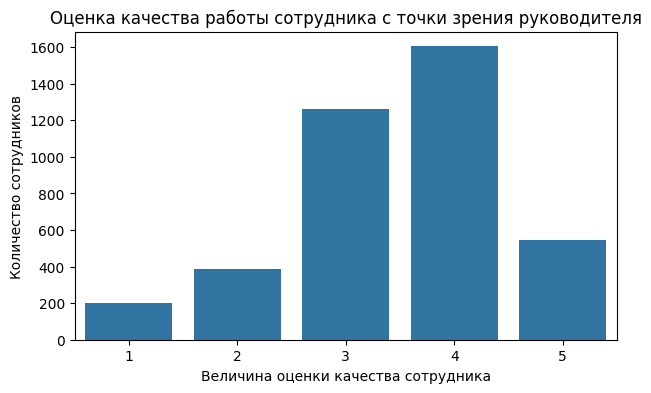

In [41]:
plt.figure(figsize=(7, 4))
sns.countplot(x = 'supervisor_evaluation', data=data_train_job_satisfaction_rate)
plt.xlabel('Величина оценки качества сотрудника')
plt.ylabel('Количество сотрудников')
plt.title('Оценка качества работы сотрудника с точки зрения руководителя')

plt.show()

Видим, что большинство сотрудников работает хорошо или удовлетворительно с точки зрения руководителя.
Две категории, обозначающие неудовлетворительное качество работы, являются самыми малочисленными.

Посмотрим на «salary» (зарплата).

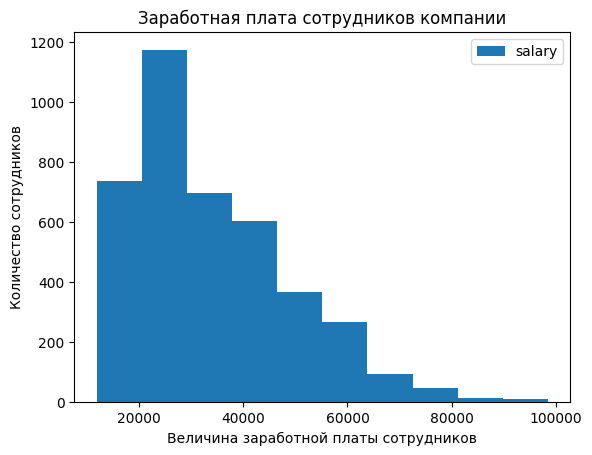

In [42]:
data_train_job_satisfaction_rate \
    .plot(kind='hist',
          y='salary',
          xlabel='Величина заработной платы сотрудников',
          ylabel='Количество сотрудников',
          title='Заработная плата сотрудников компании');

Мы видим, что большинство сотрудинков (мода) зарабатывает от 20 до 30 тыс. руб.
Далее количество сотрудников в компании с соответствующей зарплатой убывает с ростом показателя заработной платы.

Посмотрим на признак «job_satisfaction_rate» (уровень удовлетворённости сотрудника работой в компании).

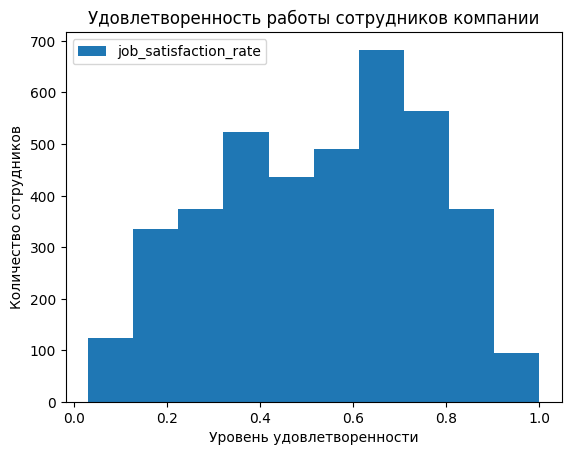

In [43]:
data_train_job_satisfaction_rate \
    .plot(kind='hist',
          y='job_satisfaction_rate',
          xlabel='Уровень удовлетворенности',
          ylabel='Количество сотрудников',
          title='Удовлетворенность работы сотрудников компании');

Мы видим, что большинство сотрудников скорее удовлетворено работой в компании (показатель выше 0.5), однако перевес небольшой.
Количество недовольных весьма велико, в связи с чем прогноз оттока сотрудиков — очень актуальная задача.

Посмотрим теперь на распределение категориальных признаков

Рассмотрим распределение сотрудников по отделам.

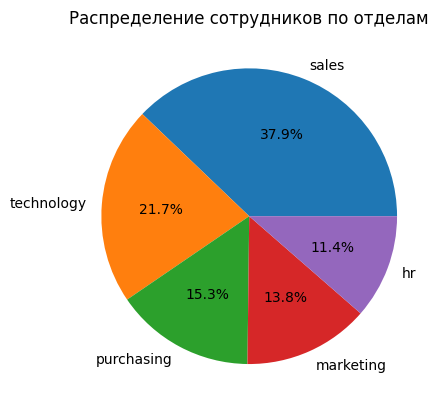

In [44]:
data_train_job_satisfaction_rate['dept'] \
    .value_counts() \
    .plot(kind='pie', ylabel='', title='Распределение сотрудников по отделам', autopct='%1.1f%%');

Видим, что большинство сотрудников ($38\%$) работает в отделе продаж, затем идет технический отдел ($21\%$),
а замыкает тройку отдел закупок ($15.3\%$).

Посмотрим на распределение сотрудников по уровням занимаемых должностей.

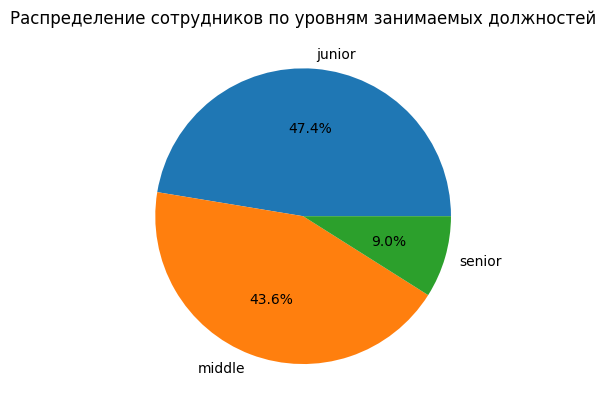

In [45]:
data_train_job_satisfaction_rate['level'] \
    .value_counts() \
    .plot(kind='pie', ylabel='', title='Распределение сотрудников по уровням занимаемых должностей', autopct='%1.1f%%');

Видим, что junior'ов и middle'ов почти поровну (junior'ов больше на ), senior'ов мало.

Посмотрим на распределение сотрудников по рабочей нагрузке.

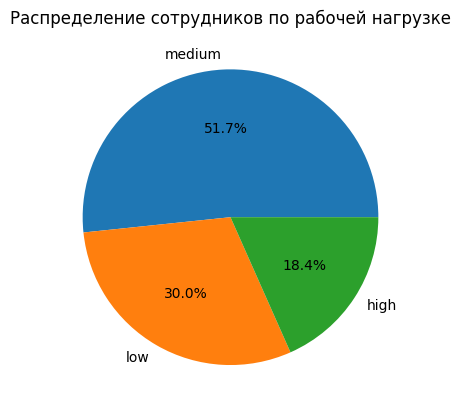

In [46]:
data_train_job_satisfaction_rate['workload'] \
    .value_counts() \
    .plot(kind='pie', ylabel='', title='Распределение сотрудников по рабочей нагрузке', autopct='%1.1f%%');

Видим, что рабочая нагрузка низкая и средняя у чуть более, чем $80\%$ сотрудников.
У менее чем $20\%$ сотрудников рабочая нагрузка высокая.

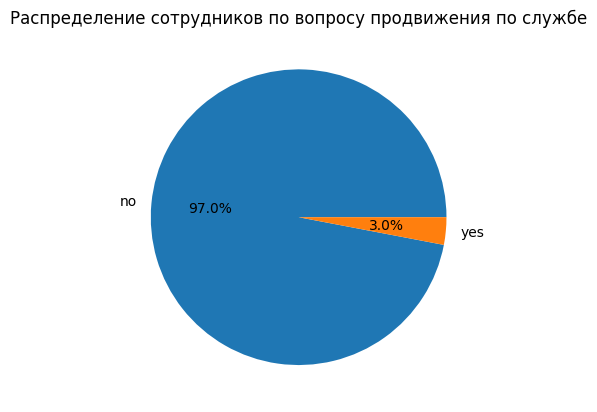

In [47]:
data_train_job_satisfaction_rate['last_year_promo'] \
    .value_counts() \
    .plot(kind='pie', ylabel='', title='Распределение сотрудников по вопросу продвижения по службе', autopct='%1.1f%%');

Подавляющее большинство сотрудников (более $97\%$) не получало продвжения по службе за последний год.

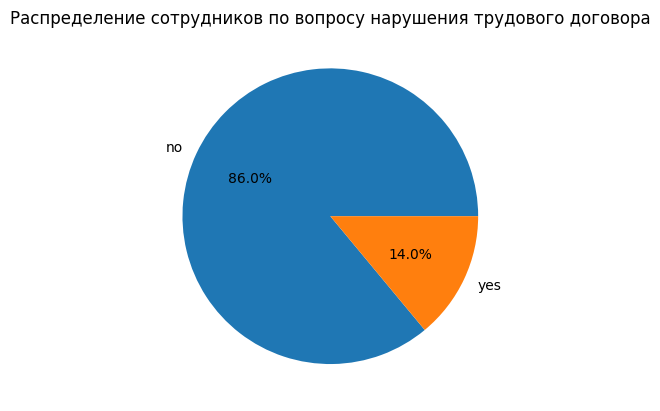

In [48]:
data_train_job_satisfaction_rate['last_year_violations'] \
    .value_counts() \
    .plot(kind='pie', ylabel='', title='Распределение сотрудников по вопросу нарушения трудового договора', autopct='%1.1f%%');

В целом, сотрудники дисциплинированны и не нарушают подписанный трудовой договор.

##### test_features

In [49]:
data_test_features.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 9 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   id                     2000 non-null   int64 
 1   dept                   1998 non-null   object
 2   level                  1999 non-null   object
 3   workload               2000 non-null   object
 4   employment_years       2000 non-null   int64 
 5   last_year_promo        2000 non-null   object
 6   last_year_violations   2000 non-null   object
 7   supervisor_evaluation  2000 non-null   int64 
 8   salary                 2000 non-null   int64 
dtypes: int64(4), object(5)
memory usage: 140.8+ KB


Посмотрим на описательную статистику числовых признаков.

In [50]:
data_test_features.loc[:, data_test_features.columns != 'id'].describe()

,employment_years,supervisor_evaluation,salary
count,2000.000000,2000.000000,2000.000000
mean,3.666500,3.526500,34066.800000
std,2.537222,0.996892,15398.436729
min,1.000000,1.000000,12000.000000
25%,1.000000,3.000000,22800.000000
50%,3.000000,4.000000,30000.000000
75%,6.000000,4.000000,43200.000000
max,10.000000,5.000000,96000.000000


Видим, что данные корректны, аномалий нет.

Посмотрим на распределения числовых признаков.

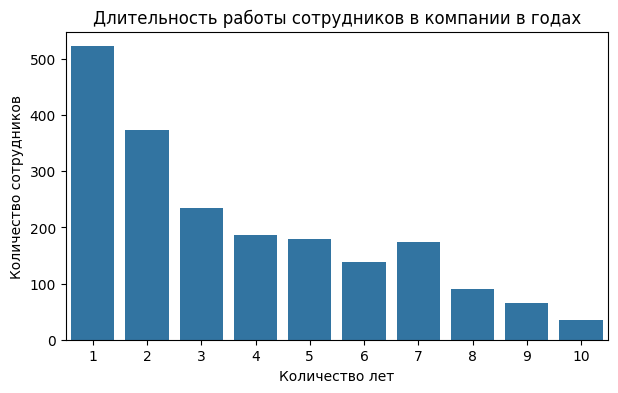

In [51]:
plt.figure(figsize=(7, 4))
sns.countplot(x = 'employment_years', data=data_test_features)
plt.xlabel('Количество лет')
plt.ylabel('Количество сотрудников')
plt.title('Длительность работы сотрудников в компании в годах')

plt.show()

Видим в целом аналогичную тренировочному датасету картину: убывающий профиль — сотрудников в компании тем меньше, чем они дольше работают
в компании.

Видим в целом аналогичную тренировочному датасету картину: убывающий профиль — сотрудников в компании тем меньше, чем они дольше работают
в компании.

Посмотрим на распределение признака «supervisor_evaluation».

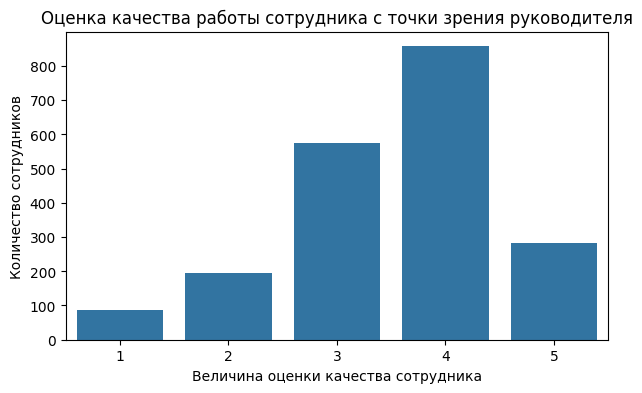

In [52]:
plt.figure(figsize=(7, 4))
sns.countplot(x = 'supervisor_evaluation', data=data_test_features)
plt.xlabel('Величина оценки качества сотрудника')
plt.ylabel('Количество сотрудников')
plt.title('Оценка качества работы сотрудника с точки зрения руководителя')

plt.show()

Видим, что большинство сотрудников из тестовой выборки работает хорошо или удовлетворительно с точки зрения руководителя.
Две категории, обозначающие неудовлетворительное качество работы, являются самыми малочисленными.

Рассмотрим распределение признака «salary» (уровень заработной платы)

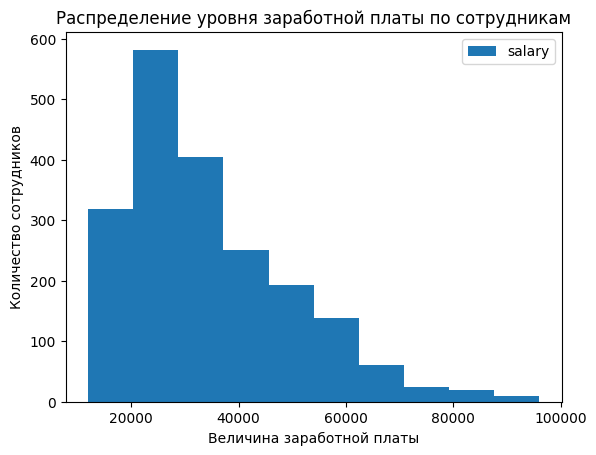

In [53]:
data_test_features \
    .plot(kind='hist',
          y='salary',
          xlabel='Величина заработной платы',
          ylabel='Количество сотрудников',
          title='Распределение уровня заработной платы по сотрудникам');

Мы видим, что большинство сотрудинков из тестовой выборки (мода) зарабатывает от 20 до 30 тыс. руб.
Далее количество сотрудников в компании с соответствующей зарплатой убывает с ростом показателя заработной платы.

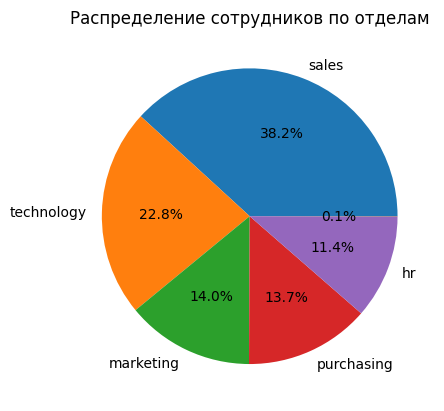

In [54]:
data_test_features['dept'] \
    .value_counts() \
    .plot(kind='pie', ylabel='', title='Распределение сотрудников по отделам', autopct='%1.1f%%');

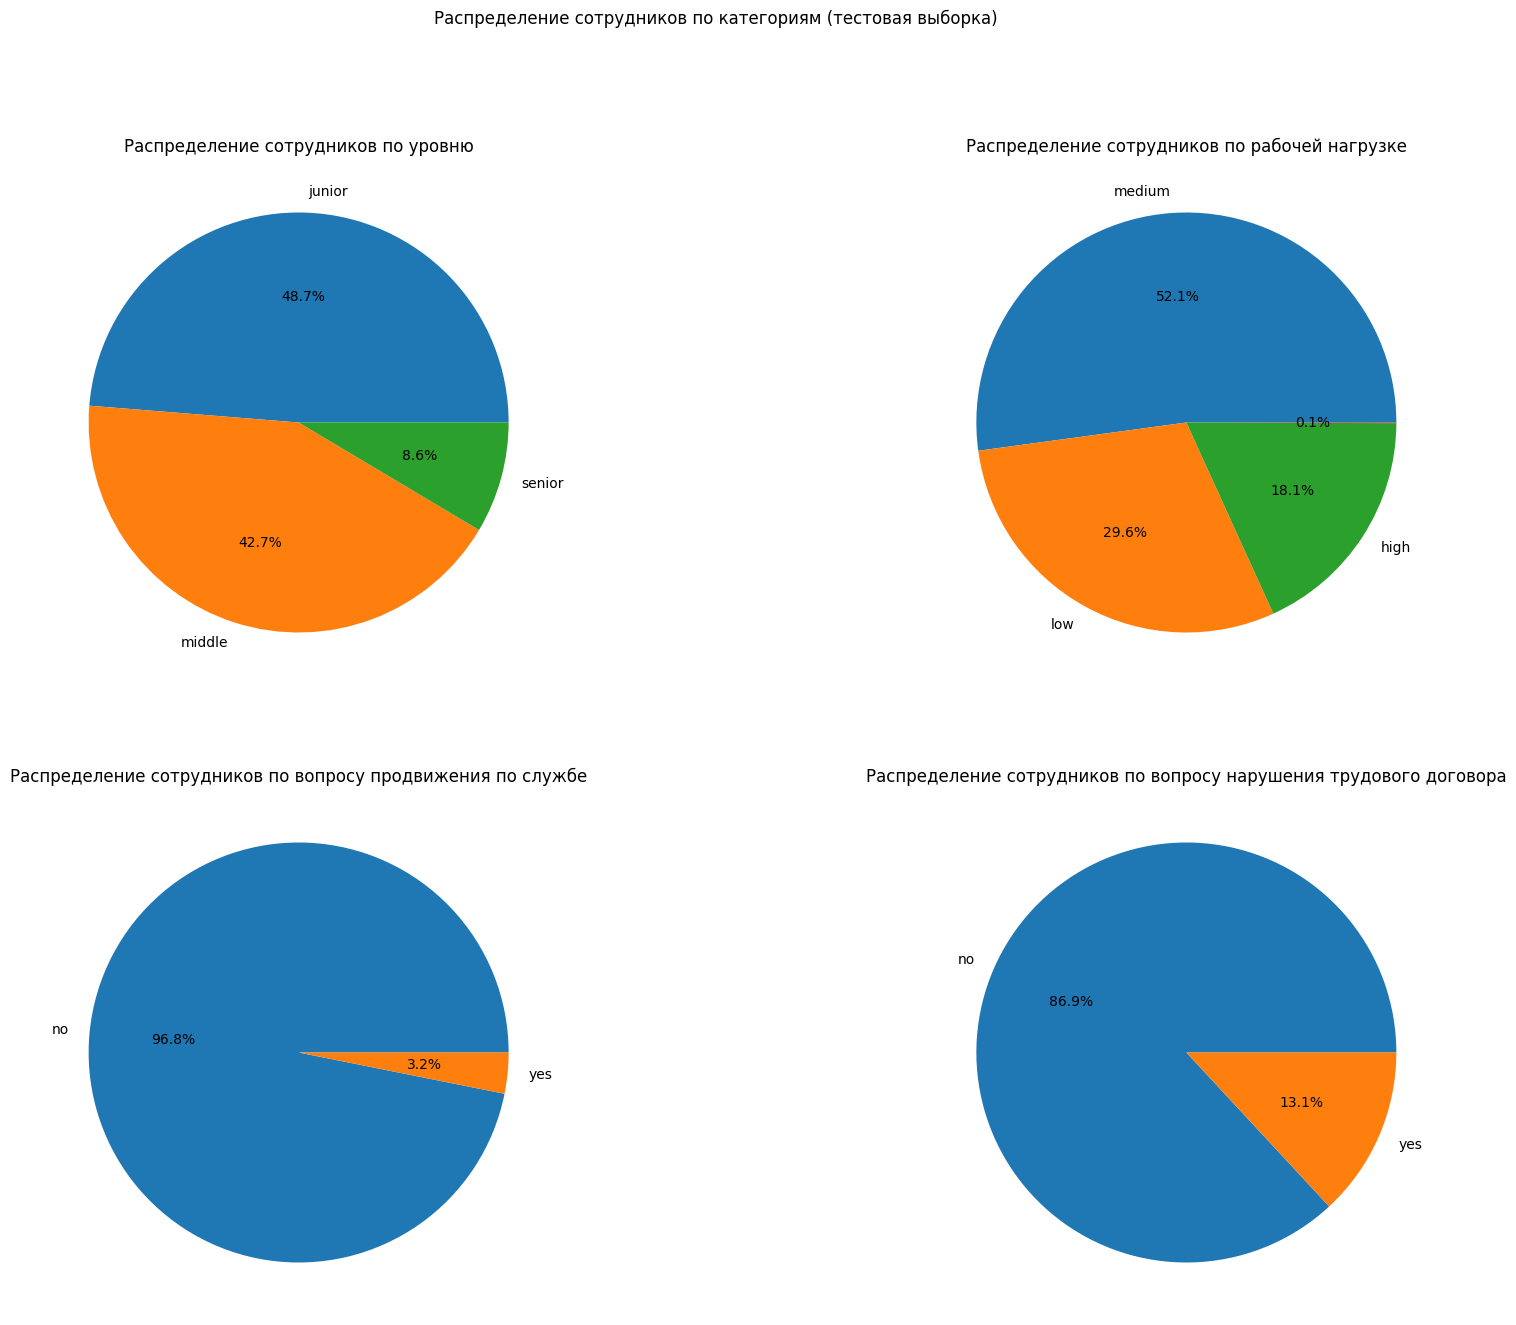

In [55]:
fig, ax = plt.subplots(2, 2, figsize=(21, 15))
fig.suptitle('Распределение сотрудников по категориям (тестовая выборка)')

data_test_features['level'] \
    .value_counts() \
    .plot(ax=ax[0][0], kind='pie', ylabel='', title='Распределение сотрудников по уровню', autopct='%1.1f%%');

data_test_features['workload'] \
    .value_counts() \
    .plot(ax=ax[0][1], kind='pie', ylabel='', title='Распределение сотрудников по рабочей нагрузке', autopct='%1.1f%%');

data_test_features['last_year_promo'] \
    .value_counts() \
    .plot(ax=ax[1][0], kind='pie', ylabel='', title='Распределение сотрудников по вопросу продвижения по службе', autopct='%1.1f%%');

data_test_features['last_year_violations'] \
    .value_counts() \
    .plot(ax=ax[1][1], kind='pie', ylabel='', title='Распределение сотрудников по вопросу нарушения трудового договора', autopct='%1.1f%%');

В целом, мы видим картину, аналогичную тренировочной выборке.
Тренировочный и тестовый датасет в целом однородны (с учетом последнего, целевого признака, рассмотренного ниже).

##### test_target_job_satisfaction_rate

In [56]:
data_test_target_job_satisfaction_rate.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 2 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   id                     2000 non-null   int64  
 1   job_satisfaction_rate  2000 non-null   float64
dtypes: float64(1), int64(1)
memory usage: 31.4 KB


Посмотрим описательную статистику признака «job_satisfaction_rate» (уровень удовлетворённости сотрудника работой в компании)

In [57]:
data_test_target_job_satisfaction_rate.loc[:, data_test_target_job_satisfaction_rate.columns != 'id'].describe()

,job_satisfaction_rate
count,2000.00000
mean,0.54878
std,0.22011
min,0.03000
25%,0.38000
50%,0.58000
75%,0.72000
max,1.00000


Данные корректны, аномалий нет.

Посмотрим на распределение признака.

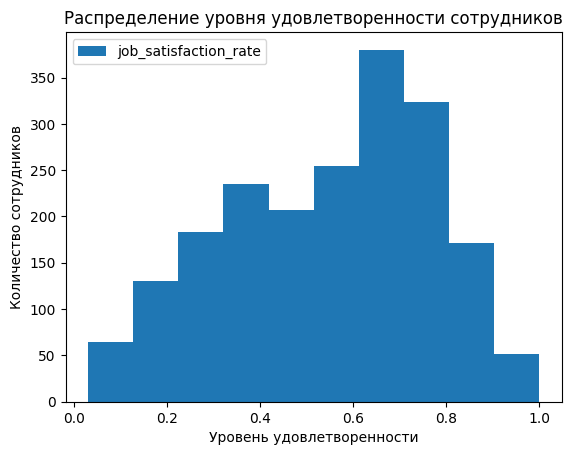

In [58]:
data_test_target_job_satisfaction_rate \
    .plot(kind='hist',
          y='job_satisfaction_rate',
          xlabel='Уровень удовлетворенности',
          ylabel='Количество сотрудников',
          title='Распределение уровня удовлетворенности сотрудников');

Мы видим, что большинство сотрудников скорее удовлетворено работой в компании (показатель выше 0.5), однако перевес также
(как и у тренировочной выборки) небольшой.

#### Корреляционный анализ

In [59]:
interval_cols = ['job_satisfaction_rate', 'salary']

phik_overview = phik_matrix(data_train_job_satisfaction_rate.drop('id', axis=1), interval_cols=interval_cols) 

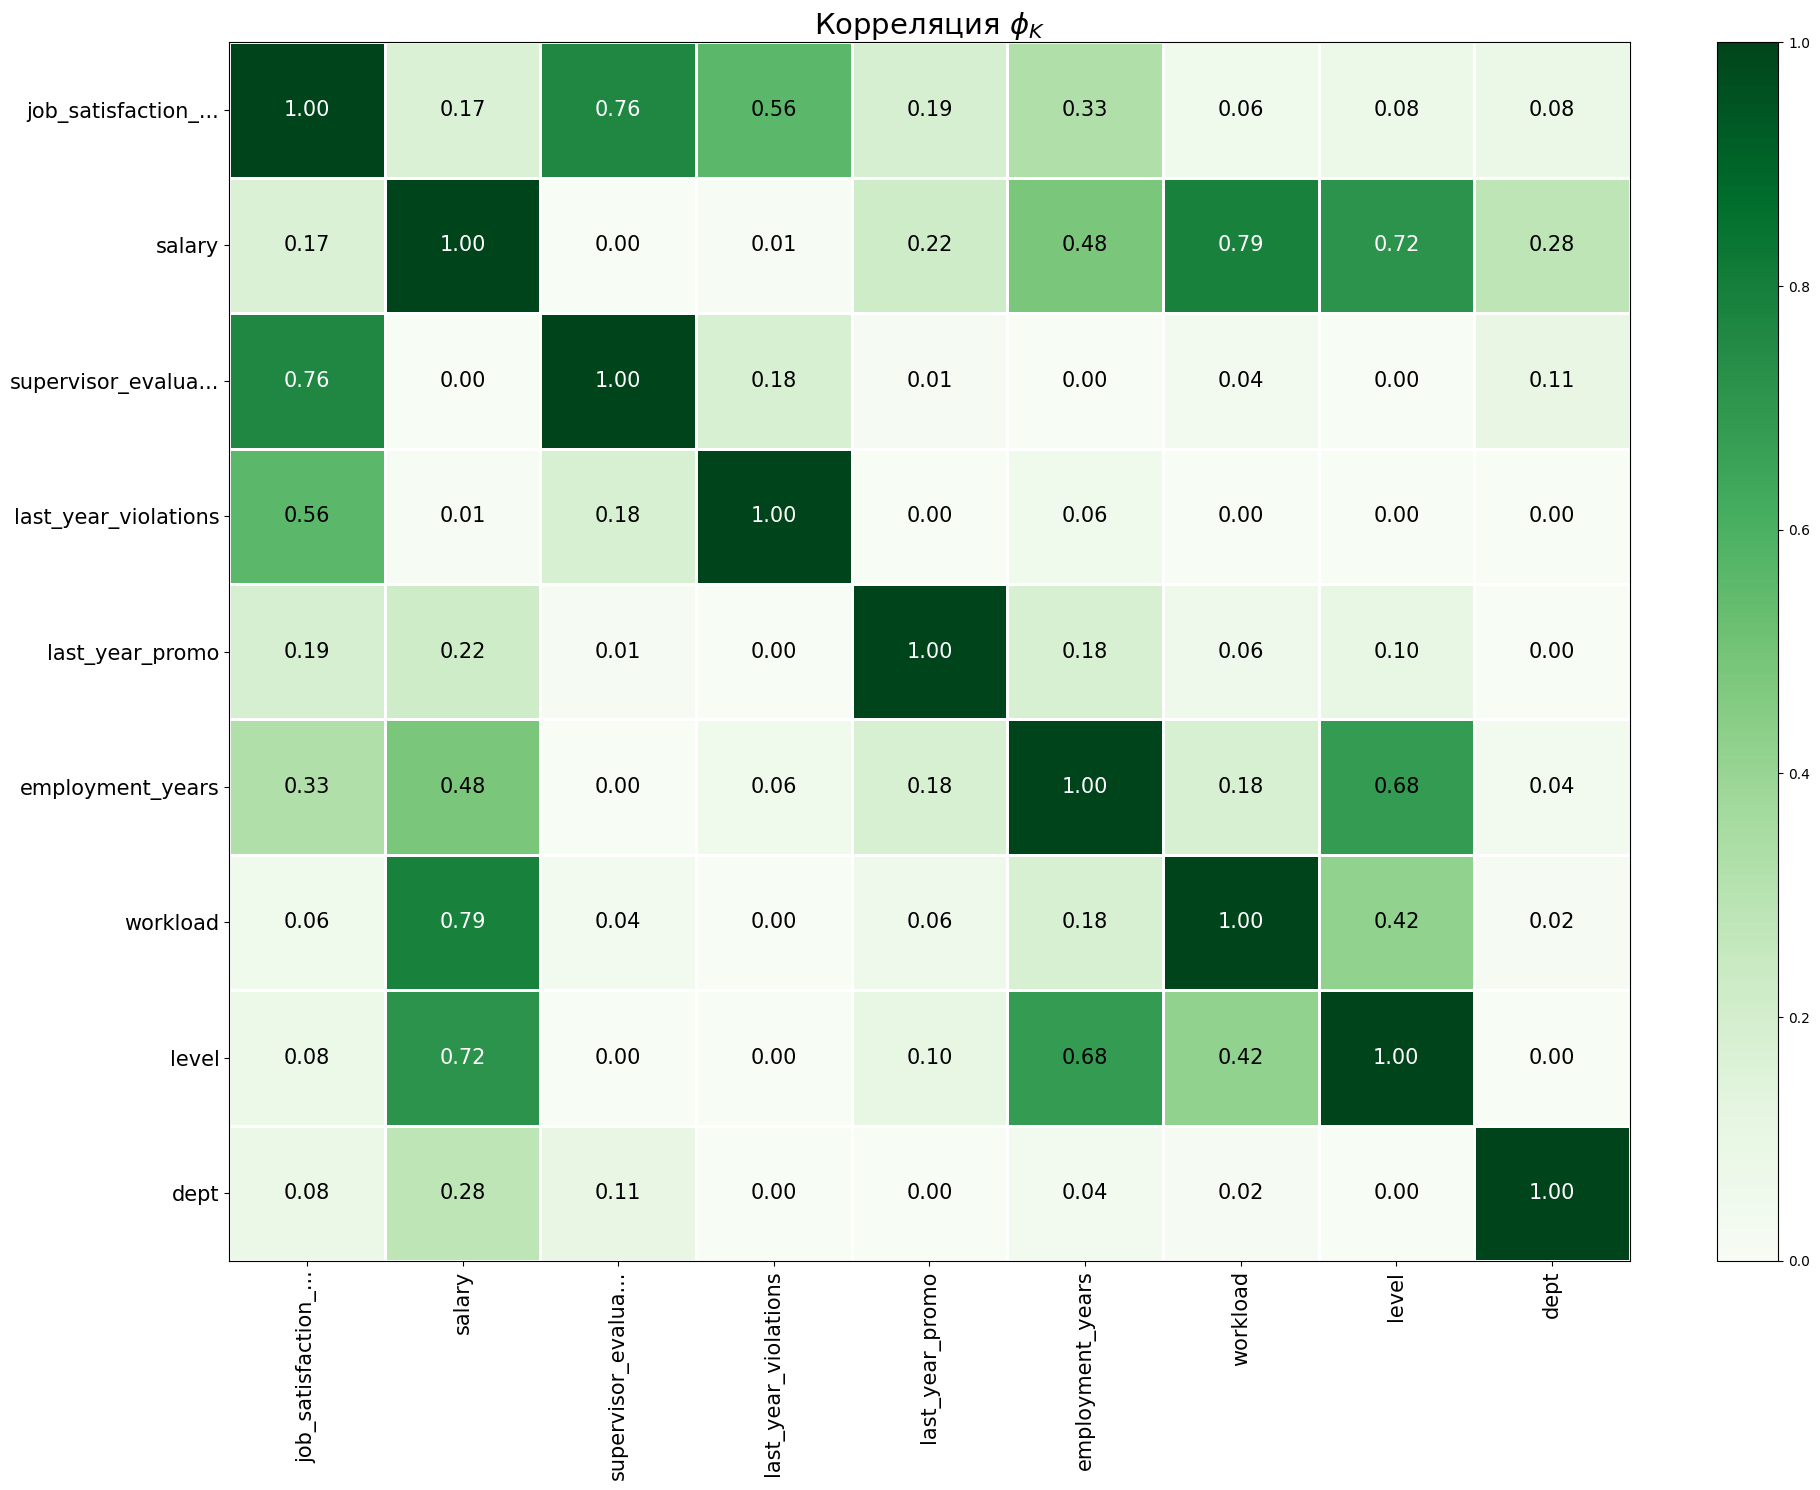

In [60]:
plot_correlation_matrix(
    phik_overview.values,
    x_labels=phik_overview.columns,
    y_labels=phik_overview.index,
    vmin=0, vmax=1, color_map='Greens',
    title=r'Корреляция $\phi_K$',
    fontsize_factor=1.5,
    figsize=(20, 15)
) 

Видим, что у целевого признака «job_satisfaction_rate» самая сильная корреляция имеется с признаком  supervisor_evaluation (оценка качества 
работы сотрудника с точки зрения руководителя) и умеренная (от 0.5 до 0.7) — «last_year_violations» (нарушал ли сотрудник трудовой договор
за последний год).
С остальными признаками зависимость либо слабая, либо ее вообще нет.

В целом, сильно выраженная (0.9 или выше) мультиколлинеарность между признаками отсутствует.
Оставим их все.

Теперь проведем корреляционный анализ для тестовой выборки.

In [61]:
interval_cols = ['salary']

phik_overview = phik_matrix(data_test_features \
                                .assign(job_satisfaction_rate=data_test_target_job_satisfaction_rate['job_satisfaction_rate']) \
                                .drop('id', axis=1), interval_cols=interval_cols) 

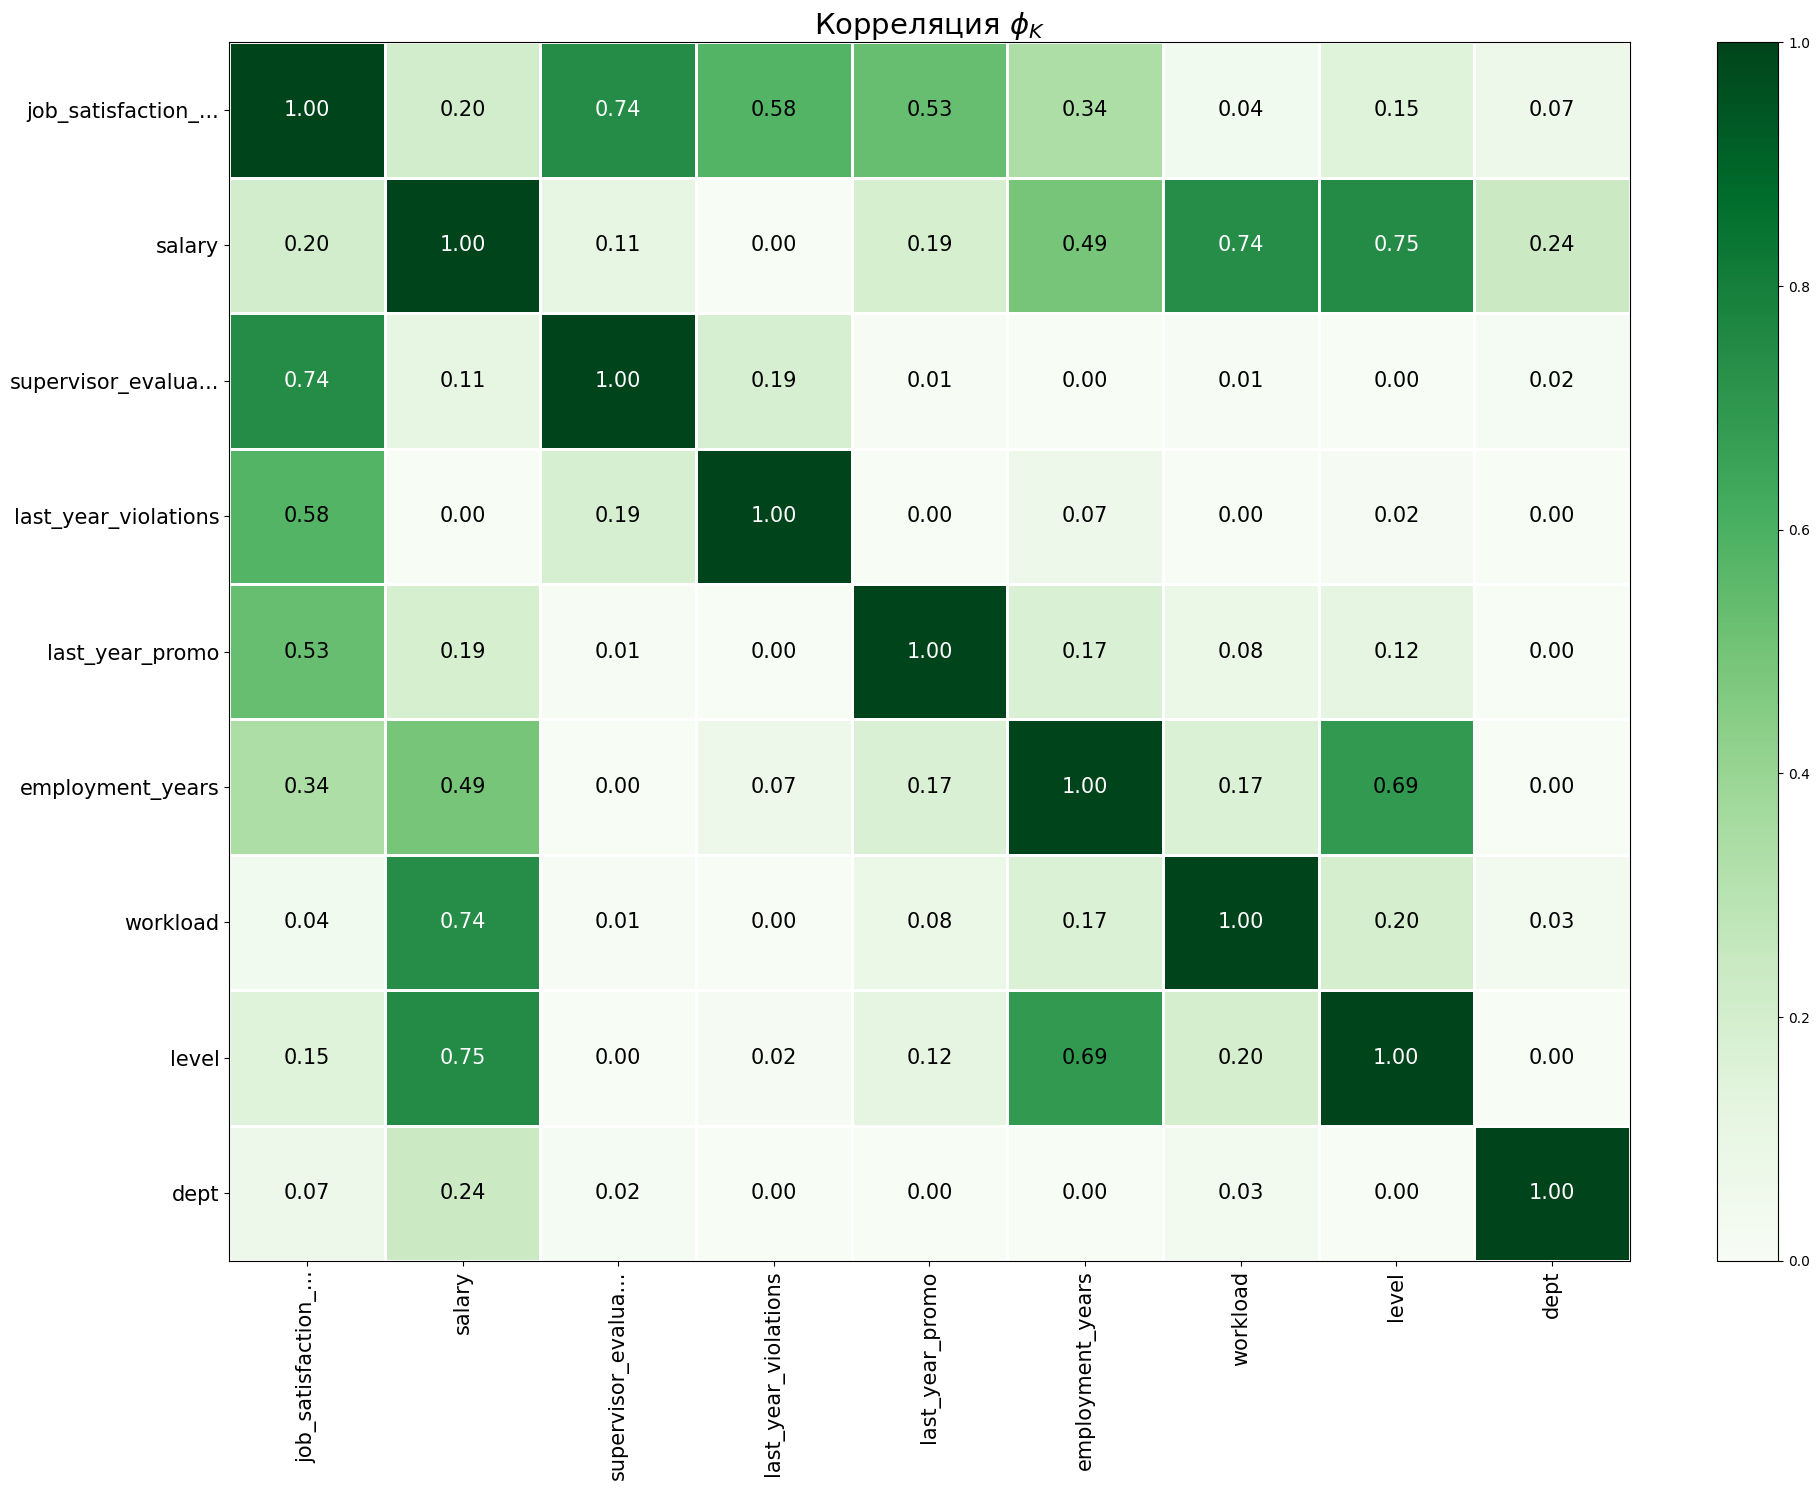

In [62]:
plot_correlation_matrix(
    phik_overview.values,
    x_labels=phik_overview.columns,
    y_labels=phik_overview.index,
    vmin=0, vmax=1, color_map='Greens',
    title=r'Корреляция $\phi_K$',
    fontsize_factor=1.5,
    figsize=(20, 15)
) 

В тестовой выборке, как мы видим, у целевого признака «job_satisfaction_rate» также наблюдается самая сильная корреляция с признаком
«supervisor_evaluation» (оценка качества работы сотрудника с точки зрения руководителя) и умеренная (от 0.5 до 0.7) — 
«last_year_violations» (нарушал ли сотрудник трудовой договор за последний год) и «last_year_promo» (было ли повышение за последний год).
С остальными признаками зависимость либо слабая, либо ее вообще нет.

Сильно выраженная (0.9 или выше) мультиколлинеарность между признаками в тестовой выборке также отсутствует.

В целом, в тестовой выборке между тренировочной и тестовой выборками существенных различий нет (в одном признаке отличие лишь на 1 десятую,
в остальных — в пределах сотых единиц).

Итак, подготовим признаки следующим образом:
* Для категориальных признаков заполним пропуски с помощью SimpleImputer самым часто встречающимся значением в столбце.
  Далее применим прямое кодирование, в ходе которого новые, ранее не виденные категории (в частности пробел в одном из признаков,
  обнаруженный нами в ходе предобработки данных), проигнорируем.
* Для порядковых категорий сначала заполним пропуски с помощью SimpleImputer самым частовстречающимся значением.
  Затем закодируем категории с помощью Ordinal Encoder, заместив возможные новые, ранее не встречавшиеся категории NaN'ом.
  После этого опять вызовем SimpleImputer и закодируем NaN'ы самым частовстречающимся значением.
* Для числовых выберем 2 метода масштабирования.

### Подготовка данных

Т.к. тренировочные и тестовые данные уже даны по условию, то разбиение не требуется.

In [63]:
X_train = data_train_job_satisfaction_rate.drop(['id', 'job_satisfaction_rate'], axis=1)

In [62]:
y_train = data_train_job_satisfaction_rate['job_satisfaction_rate']

In [63]:
X_test = data_test_features.drop(['id'], axis=1)

In [64]:
y_test = data_test_target_job_satisfaction_rate['job_satisfaction_rate']

Создадим списки с признаками:

In [65]:
feature_cat_cols = ['dept', 'last_year_promo', 'last_year_violations']
feature_ord_cols = ['level', 'workload']

In [66]:
feature_num_cols = ['employment_years', 'salary', 'supervisor_evaluation']

Создадим пайплайн для подготовки категориальных признаков: заполнение пропусков и прямое кодирование

In [67]:
cat_cols_pipe = Pipeline(
    [
        ('simpleImputer_ohe', SimpleImputer(missing_values=np.nan, strategy='most_frequent')),
        ('simpleImputer_ohe_2', SimpleImputer(missing_values=' ', strategy='most_frequent')),
        ('ohe', OneHotEncoder(drop='first', handle_unknown='ignore', sparse_output=False))
    ]
)

Создадим пайплайн для подготовки порядковых признаков: заполнение пропусков и порядковое кодирование

In [68]:
cat_ord_pipe = Pipeline(
    [('simpleImputer_before_ord', SimpleImputer(missing_values=np.nan, strategy='most_frequent')),
     ('ord',  OrdinalEncoder(
                categories=[
                    ['junior', 'middle', 'senior'], 
                    ['low', 'medium', 'high']
                ], 
                handle_unknown='use_encoded_value', unknown_value=np.nan
            )
        ),
     ('simpleImputer_after_ord', SimpleImputer(missing_values=np.nan, strategy='most_frequent'))
    ]
)

Создадим общий пайплайн для подготовки данных

In [69]:
data_preprocessor = ColumnTransformer(
    [('ohe', cat_cols_pipe, feature_cat_cols),
     ('ord', cat_ord_pipe, feature_ord_cols),
     ('num', MinMaxScaler(), feature_num_cols)
    ], 
    remainder='passthrough'
)

### Обучение моделей

Создаем окончательный пайплайн

In [70]:
pipe_final = Pipeline([
    ('preprocessor', data_preprocessor),
    ('models', DecisionTreeRegressor(random_state=RANDOM_STATE))
])

Словари для моделей

In [71]:
param_grid = [
    {
        'models': [LinearRegression()],
         'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']  
    },
    
    {
        'models': [DecisionTreeRegressor(
            random_state=RANDOM_STATE 
        )],
        'models__max_depth': range(2, 12),
        'models__min_samples_split': range(2, 5),
        'models__min_samples_leaf': range(1, 5),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']
    }
]

Создаем собственную метрику

In [72]:
def smape_metric(y_true, y_pred):
    
    return 100 / len(y_true) * sum(np.abs(y_true - y_pred) / ((np.abs(y_true) + np.abs(y_pred)) / 2))

scorer_smape = make_scorer(smape_metric, greater_is_better=False)

Запускаем автоматический подбор модели.

In [73]:
grid = GridSearchCV(
    pipe_final, 
    param_grid=param_grid, 
    cv=5, 
    scoring=scorer_smape,
    n_jobs=-1
)
grid.fit(X_train, y_train);
print(grid.best_estimator_)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ohe',
                                                  Pipeline(steps=[('simpleImputer_ohe',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('simpleImputer_ohe_2',
                                                                   SimpleImputer(missing_values=' ',
                                                                                 strategy='most_frequent')),
                                                                  ('ohe',
                                                                   OneHotEncoder(drop='first',
                                                                                 handle_unknown='ignore',
                                                                              

Значение метрики на кросс-валидации (умножаем на (-1), т.к. мы минимизируем метрику и make_scorer умножает ее значение на -1)

In [74]:
print(grid.best_score_ * (-1))

14.712379262823168


Получим прогноз на тестовой выборке

In [75]:
y_pred_first_task = grid.predict(X_test)

Посмотрим значение метрики на тестовой выборке

In [76]:
smape_metric(y_test, y_pred_first_task)

14.264665125742662

Целевое значение метрики SMAPE на тестовой выборке (15) достигнуто!

Сохраним рассмотренные модели.

In [77]:
result = pd.DataFrame(grid.cv_results_)

10 лучших моделей:

In [78]:
result[['rank_test_score', 'param_models', 'mean_test_score','params']].sort_values('rank_test_score').head(10)

,rank_test_score,param_models,mean_test_score,params
352,1,DecisionTreeRegressor(random_state=12345),-14.712379,"{'models': DecisionTreeRegressor(random_state=12345), 'models__max_depth': 11, 'models__min_samples_leaf': 3, 'models__min_samples_split': 4, 'preprocessor__num': MinMaxScaler()}"
349,1,DecisionTreeRegressor(random_state=12345),-14.712379,"{'models': DecisionTreeRegressor(random_state=12345), 'models__max_depth': 11, 'models__min_samples_leaf': 3, 'models__min_samples_split': 3, 'preprocessor__num': MinMaxScaler()}"
346,1,DecisionTreeRegressor(random_state=12345),-14.712379,"{'models': DecisionTreeRegressor(random_state=12345), 'models__max_depth': 11, 'models__min_samples_leaf': 3, 'models__min_samples_split': 2, 'preprocessor__num': MinMaxScaler()}"
345,4,DecisionTreeRegressor(random_state=12345),-14.723775,"{'models': DecisionTreeRegressor(random_state=12345), 'models__max_depth': 11, 'models__min_samples_leaf': 3, 'models__min_samples_split': 2, 'preprocessor__num': StandardScaler()}"
351,4,DecisionTreeRegressor(random_state=12345),-14.723775,"{'models': DecisionTreeRegressor(random_state=12345), 'models__max_depth': 11, 'models__min_samples_leaf': 3, 'models__min_samples_split': 4, 'preprocessor__num': StandardScaler()}"
348,4,DecisionTreeRegressor(random_state=12345),-14.723775,"{'models': DecisionTreeRegressor(random_state=12345), 'models__max_depth': 11, 'models__min_samples_leaf': 3, 'models__min_samples_split': 3, 'preprocessor__num': StandardScaler()}"
347,7,DecisionTreeRegressor(random_state=12345),-14.730393,"{'models': DecisionTreeRegressor(random_state=12345), 'models__max_depth': 11, 'models__min_samples_leaf': 3, 'models__min_samples_split': 2, 'preprocessor__num': 'passthrough'}"
350,7,DecisionTreeRegressor(random_state=12345),-14.730393,"{'models': DecisionTreeRegressor(random_state=12345), 'models__max_depth': 11, 'models__min_samples_leaf': 3, 'models__min_samples_split': 3, 'preprocessor__num': 'passthrough'}"
353,7,DecisionTreeRegressor(random_state=12345),-14.730393,"{'models': DecisionTreeRegressor(random_state=12345), 'models__max_depth': 11, 'models__min_samples_leaf': 3, 'models__min_samples_split': 4, 'preprocessor__num': 'passthrough'}"
340,10,DecisionTreeRegressor(random_state=12345),-15.067614,"{'models': DecisionTreeRegressor(random_state=12345), 'models__max_depth': 11, 'models__min_samples_leaf': 2, 'models__min_samples_split': 3, 'preprocessor__num': MinMaxScaler()}"


Итак, мы обучили две модели: линейную регрессию и дерево решений.
В качестве метрики создали свою метрику SMAPE («симметричное среднее абсолютное процентное отклонение»).
Лучшей оказалась модель дерева решений, т.к. она лучше улавливает нелинейные связи (модель линейной регрессии хорошо работает, если между целевым и входными признаками есть чёткая линейная зависимость).

Параметры лучшей модели:

In [79]:
result.sort_values('rank_test_score')['params'].iloc[0:1].item()

{'models': DecisionTreeRegressor(random_state=12345),
 'models__max_depth': 11,
 'models__min_samples_leaf': 3,
 'models__min_samples_split': 4,
 'preprocessor__num': MinMaxScaler()}

* Максимальная глубина дерева — 11
* Минимальное количество объектов для разделения — 4
* Минимальное количество объектов на листе — 3

## Предсказание увольнения сотрудника из компании

### Загрузка данных

In [80]:
filename_train_quit = 'train_quit.csv'
filename_test_features = 'test_features.csv'
filename_test_target_quit = 'test_target_quit.csv'

In [81]:
try:
    data_train_quit = pd.read_csv('/datasets/' + filename_train_quit)
except:
    data_train_quit = pd.read_csv(filename_train_quit)

In [82]:
try:
    data_test_features = pd.read_csv('/datasets/' + filename_test_features)
except:
    data_test_features = pd.read_csv(filename_test_features)

In [83]:
try:
    data_test_target_quit = pd.read_csv('/datasets/' + filename_test_target_quit)
except:
    data_test_target_quit = pd.read_csv(filename_test_target_quit)

#### Осмотр данных

Посмотрим на датасеты. Датасет data_test_features был осмотрен нами в ходе решения первой задачи.

##### data_train_quit

In [84]:
data_train_quit.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 10 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   id                     4000 non-null   int64 
 1   dept                   4000 non-null   object
 2   level                  4000 non-null   object
 3   workload               4000 non-null   object
 4   employment_years       4000 non-null   int64 
 5   last_year_promo        4000 non-null   object
 6   last_year_violations   4000 non-null   object
 7   supervisor_evaluation  4000 non-null   int64 
 8   salary                 4000 non-null   int64 
 9   quit                   4000 non-null   object
dtypes: int64(4), object(6)
memory usage: 312.6+ KB


Видим, что датасет полный (NaN'ов нет).
Столбцы наименованы в соответствии со стандартным стилем.

Посмотрим на первые 5 строк.

In [85]:
data_train_quit.head()

,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,quit
0,723290,sales,middle,high,2,no,no,4,54000,no
1,814010,sales,junior,medium,2,no,no,4,27600,no
2,155091,purchasing,middle,medium,5,no,no,1,37200,no
3,257132,sales,junior,medium,2,no,yes,3,24000,yes
4,910140,marketing,junior,medium,2,no,no,5,25200,no


Датасет загрузился корректно.

##### data_test_target_quit

In [86]:
data_test_target_quit.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      2000 non-null   int64 
 1   quit    2000 non-null   object
dtypes: int64(1), object(1)
memory usage: 31.4+ KB


Датасет полный (без NaN'ов).

Посмотрим на первые 5 строк.

In [87]:
data_test_target_quit.head()

,id,quit
0,999029,yes
1,372846,no
2,726767,no
3,490105,no
4,416898,yes


Видим, что сортировка данных в рассматриваемом нами датасете с целевым признаков не совпадает с сортировкой в датасете с тестовыми признаками
(data_test_features).
Исправим это. Т.к. файл с целевыми признаками тот же, что и в первой задаче, то можем использовать ключи (key) оттуда.

In [88]:
data_test_target_quit.sort_values(by='id', key=key.reindex, inplace=True)

In [89]:
data_test_target_quit.reset_index(inplace=True, drop=True)

In [90]:
data_test_target_quit.head()

,id,quit
0,485046,no
1,686555,no
2,467458,no
3,418655,no
4,789145,no


Теперь сортировка по «id» одинакова.

### Предобработка данных

##### train_quit

Посмотрим на первые 5 строк

In [91]:
data_train_quit.head()

,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,quit
0,723290,sales,middle,high,2,no,no,4,54000,no
1,814010,sales,junior,medium,2,no,no,4,27600,no
2,155091,purchasing,middle,medium,5,no,no,1,37200,no
3,257132,sales,junior,medium,2,no,yes,3,24000,yes
4,910140,marketing,junior,medium,2,no,no,5,25200,no


Проверим уникальные значения строковых признаков на предмет наличия дубликатов и прочих аномальных значений.

In [92]:
data_train_quit['dept'].unique()

array(['sales', 'purchasing', 'marketing', 'technology', 'hr'],
      dtype=object)

Тут все корректно, повторов и аномальных наименований отделов нет.

In [93]:
data_train_quit['level'].unique()

array(['middle', 'junior', 'sinior'], dtype=object)

Тут также все хорошо.
Поменяем значения признака 'sinior' на 'senior' — так более корректно и не будет привлекать лишнее внимание.

In [94]:
data_train_quit.loc[data_train_quit['level'] == 'sinior', 'level'] = 'senior'

Рассмотрим следующий строковый признак, «workload».

In [95]:
data_train_quit['workload'].unique()

array(['high', 'medium', 'low'], dtype=object)

Тут все корректно.

In [96]:
data_train_quit['last_year_promo'].unique()

array(['no', 'yes'], dtype=object)

In [97]:
data_train_quit['last_year_violations'].unique()

array(['no', 'yes'], dtype=object)

Здесь тоже все корректно.

Проверим также целевой признак.

In [98]:
data_train_quit['quit'].unique()

array(['no', 'yes'], dtype=object)

Все хорошо: аномальных значений или пропусков нет.

<!-- Закодируем классы в явном виде следующим образом: 'no' — 0, 'yes' — 1. -->

Проверим также, все ли id уникальны.

In [99]:
data_train_quit['id'].duplicated().any()

np.False_

Все id уникальны.

Стапо быть, дубликатов строк быть не может (т.к. столбец полный и все значения уникальны).

##### test_target_quit

Посмотрим на первые 5 строк.

In [100]:
data_test_target_quit.head()

,id,quit
0,485046,no
1,686555,no
2,467458,no
3,418655,no
4,789145,no


Проверим строковые данные на предмет уникальных значений.

In [101]:
data_test_target_quit['quit'].unique()

array(['no', 'yes'], dtype=object)

Аномальных значений нет.

<!-- Аналогично случаю тренировочной выборки, закодируем метки классов по той же схеме: 'no' — 0, 'yes' — 1. -->

Проверим дубликаты «id».

In [102]:
data_test_target_quit['id'].duplicated().any()

np.False_

Дубликатов строк нет.

Предобработка данных завершена!

### Исследовательский анализ данных

##### train_quit

In [103]:
data_train_quit.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 10 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   id                     4000 non-null   int64 
 1   dept                   4000 non-null   object
 2   level                  4000 non-null   object
 3   workload               4000 non-null   object
 4   employment_years       4000 non-null   int64 
 5   last_year_promo        4000 non-null   object
 6   last_year_violations   4000 non-null   object
 7   supervisor_evaluation  4000 non-null   int64 
 8   salary                 4000 non-null   int64 
 9   quit                   4000 non-null   object
dtypes: int64(4), object(6)
memory usage: 312.6+ KB


Посмотрим описательную статистику числовых признаков.

In [104]:
data_train_quit.drop(['id', 'quit'], axis=1).describe()

,employment_years,supervisor_evaluation,salary
count,4000.000000,4000.000000,4000.000000
mean,3.701500,3.474750,33805.800000
std,2.541852,1.004049,15152.415163
min,1.000000,1.000000,12000.000000
25%,2.000000,3.000000,22800.000000
50%,3.000000,4.000000,30000.000000
75%,6.000000,4.000000,43200.000000
max,10.000000,5.000000,96000.000000


Видим, что выбросов у признаков «employment_years» и «supervisor_evaluation» выбросов нет.
Выбросы есть только у признака «salary».

Построим для него диаграмму размаха.

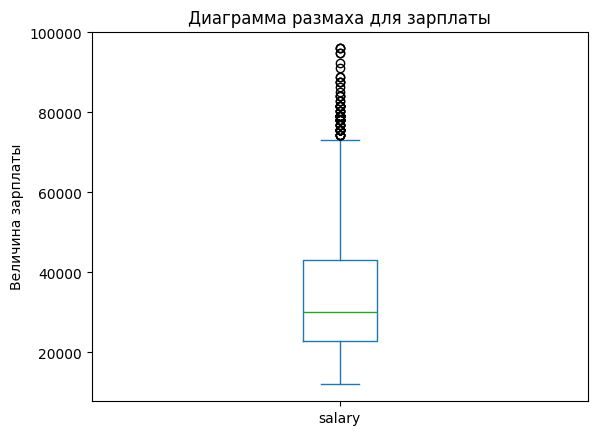

In [105]:
data_train_quit['salary'].plot(kind='box', title='Диаграмма размаха для зарплаты', ylabel='Величина зарплаты');

Очевидно аномальных выбросов нет, оставляем данные как есть.

Рассмотрим распределение числовых признаков.

Посмотрим на распределение признака «employment_years»

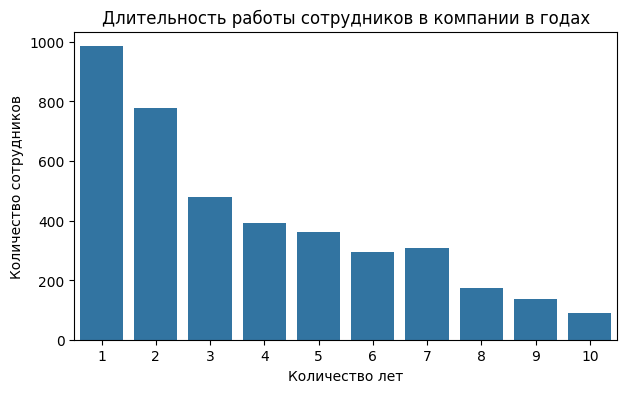

In [106]:
plt.figure(figsize=(7, 4))
sns.countplot(x = 'employment_years', data=data_train_quit)
plt.xlabel('Количество лет')
plt.ylabel('Количество сотрудников')
plt.title('Длительность работы сотрудников в компании в годах')

plt.show()

В целом, наблюдается убывающая картина (чем больше стаж, тем меньше сотрудников), аналогичная таковой из первой задачи.
Доля сотрудников в компании, отработавших не более 2х лет, самая высокая.

Рассмотрим распределение признака «supervisor_evaluation» (оценка качества работы сотрудника, которую дал руководитель).

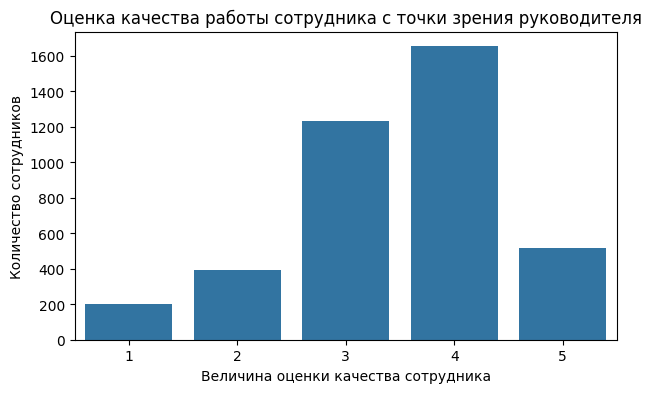

In [107]:
plt.figure(figsize=(7, 4))
sns.countplot(x = 'supervisor_evaluation', data=data_train_quit)
plt.xlabel('Величина оценки качества сотрудника')
plt.ylabel('Количество сотрудников')
plt.title('Оценка качества работы сотрудника с точки зрения руководителя')

plt.show()

Большинство (более $80\%$) сотрудников, с точки зрения руководителей, справляется с работой (оценка 3 или выше).

Рассмотрим распределение признака «salary» (заработная плата).

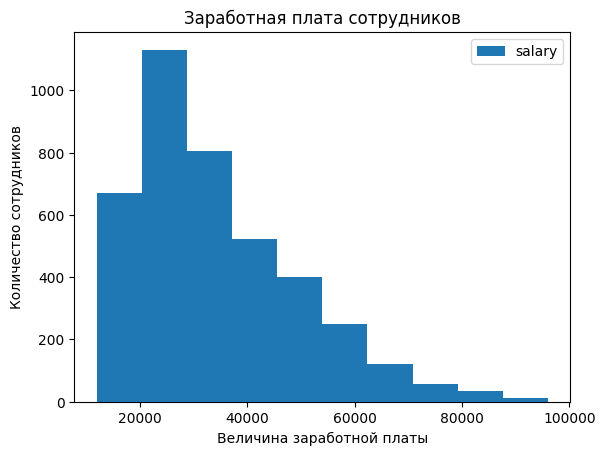

In [108]:
data_train_quit.plot(kind='hist',
                     y='salary',
                     xlabel='Величина заработной платы',
                     ylabel='Количество сотрудников',
                     title='Заработная плата сотрудников');

Большинство сотрудников заработывает от 20 до 30 тыс. руб.
Далее количество сотрудников с ростом соответствующей зарплаты убывает.

Рассмотрим распределение камтегориальных признаков

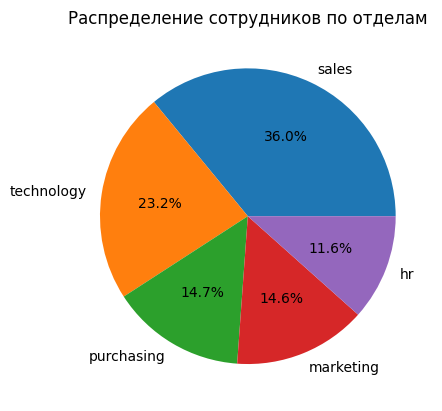

In [109]:
data_train_quit['dept'] \
    .value_counts() \
    .plot(kind='pie', ylabel='', title='Распределение сотрудников по отделам', autopct='%1.1f%%');

Большинство людей (больше трети) из отдела продаже (sales), далее идет технический отдел (technology), замыкает тройку
отдел закупок (purchasing).

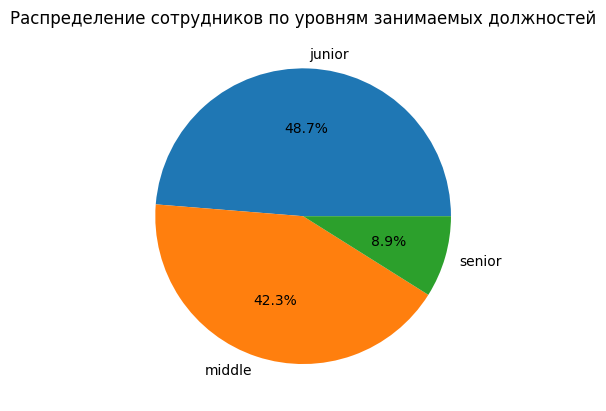

In [110]:
data_train_quit['level'] \
    .value_counts() \
    .plot(kind='pie', ylabel='', title='Распределение сотрудников по уровням занимаемых должностей', autopct='%1.1f%%');

Абсолютное большинство сотрудников ($91\%$) — младшего (junior) и среднего (middle) уровня.
Старших специалистов (senior) мало.

Посмотрим на распределение сотрудников по рабочей нагрузке.

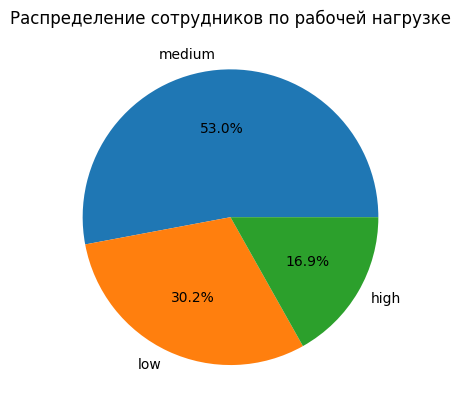

In [111]:
data_train_quit['workload'] \
    .value_counts() \
    .plot(kind='pie', ylabel='', title='Распределение сотрудников по рабочей нагрузке', autopct='%1.1f%%');

Видим, что рабочая нагрузка низкая и средняя у чуть более, чем $83\%$ сотрудников.
У менее чем $17\%$ сотрудников рабочая нагрузка высокая.

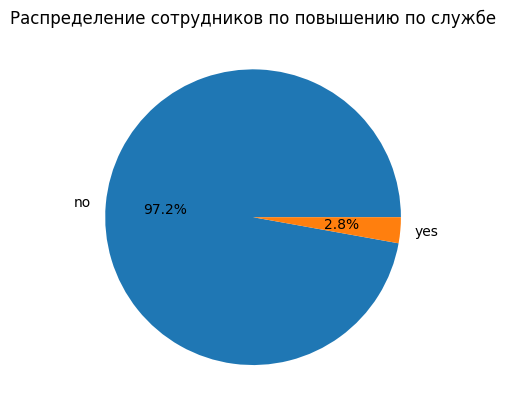

In [112]:
data_train_quit['last_year_promo'] \
    .value_counts() \
    .plot(kind='pie', ylabel='', title='Распределение сотрудников по повышению по службе', autopct='%1.1f%%');

Мы видим, что практически никто из сотрудников не получил повышение за предыдущий год

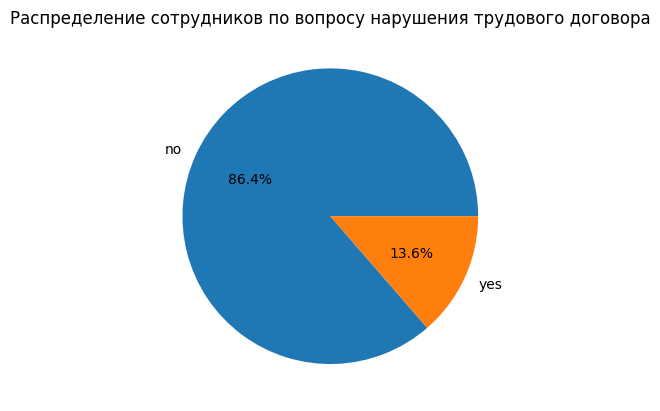

In [113]:
data_train_quit['last_year_violations'] \
    .value_counts() \
    .plot(kind='pie', ylabel='', title='Распределение сотрудников по вопросу нарушения трудового договора', autopct='%1.1f%%');

В $85\%$ случаев сотрудники не нарушали трудовой договор.

Теперь посмотрим на распределение целевого категориального признака «quit» (увольнение сотрудника компании).

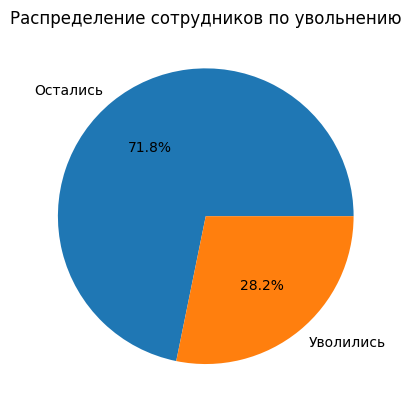

In [114]:
data_train_quit['quit'] \
    .apply(lambda x: 'Остались' if x == 'no' else 'Уволились') \
    .value_counts() \
    .plot(kind='pie', ylabel='', title='Распределение сотрудников по увольнению', autopct='%1.1f%%');

Видим, что почти в $72\%$ сотрудник не увольняется.

##### data_test_target_quit

Посмотрим на распределение целевого категориального признака в тестовой выборке.

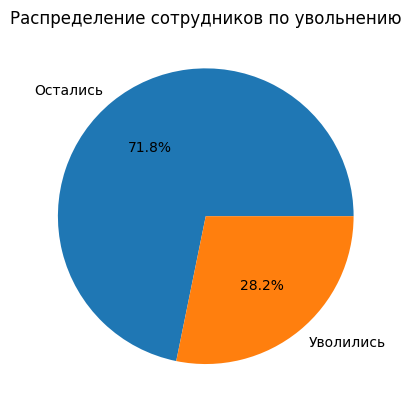

In [115]:
data_test_target_quit['quit'] \
    .apply(lambda x: 'Остались' if x == 'no' else 'Уволились') \
    .value_counts() \
    .plot(kind='pie', ylabel='', title='Распределение сотрудников по увольнению', autopct='%1.1f%%');

Видим, что пропорция классов такая же, как и в тренировочной выборке, т.е. эти выборки стратифицированы по целевому признаку.

#### Корреляционный анализ

In [116]:
interval_cols = ['salary']

phik_overview = phik_matrix(data_train_quit.drop('id', axis=1), interval_cols=interval_cols) 

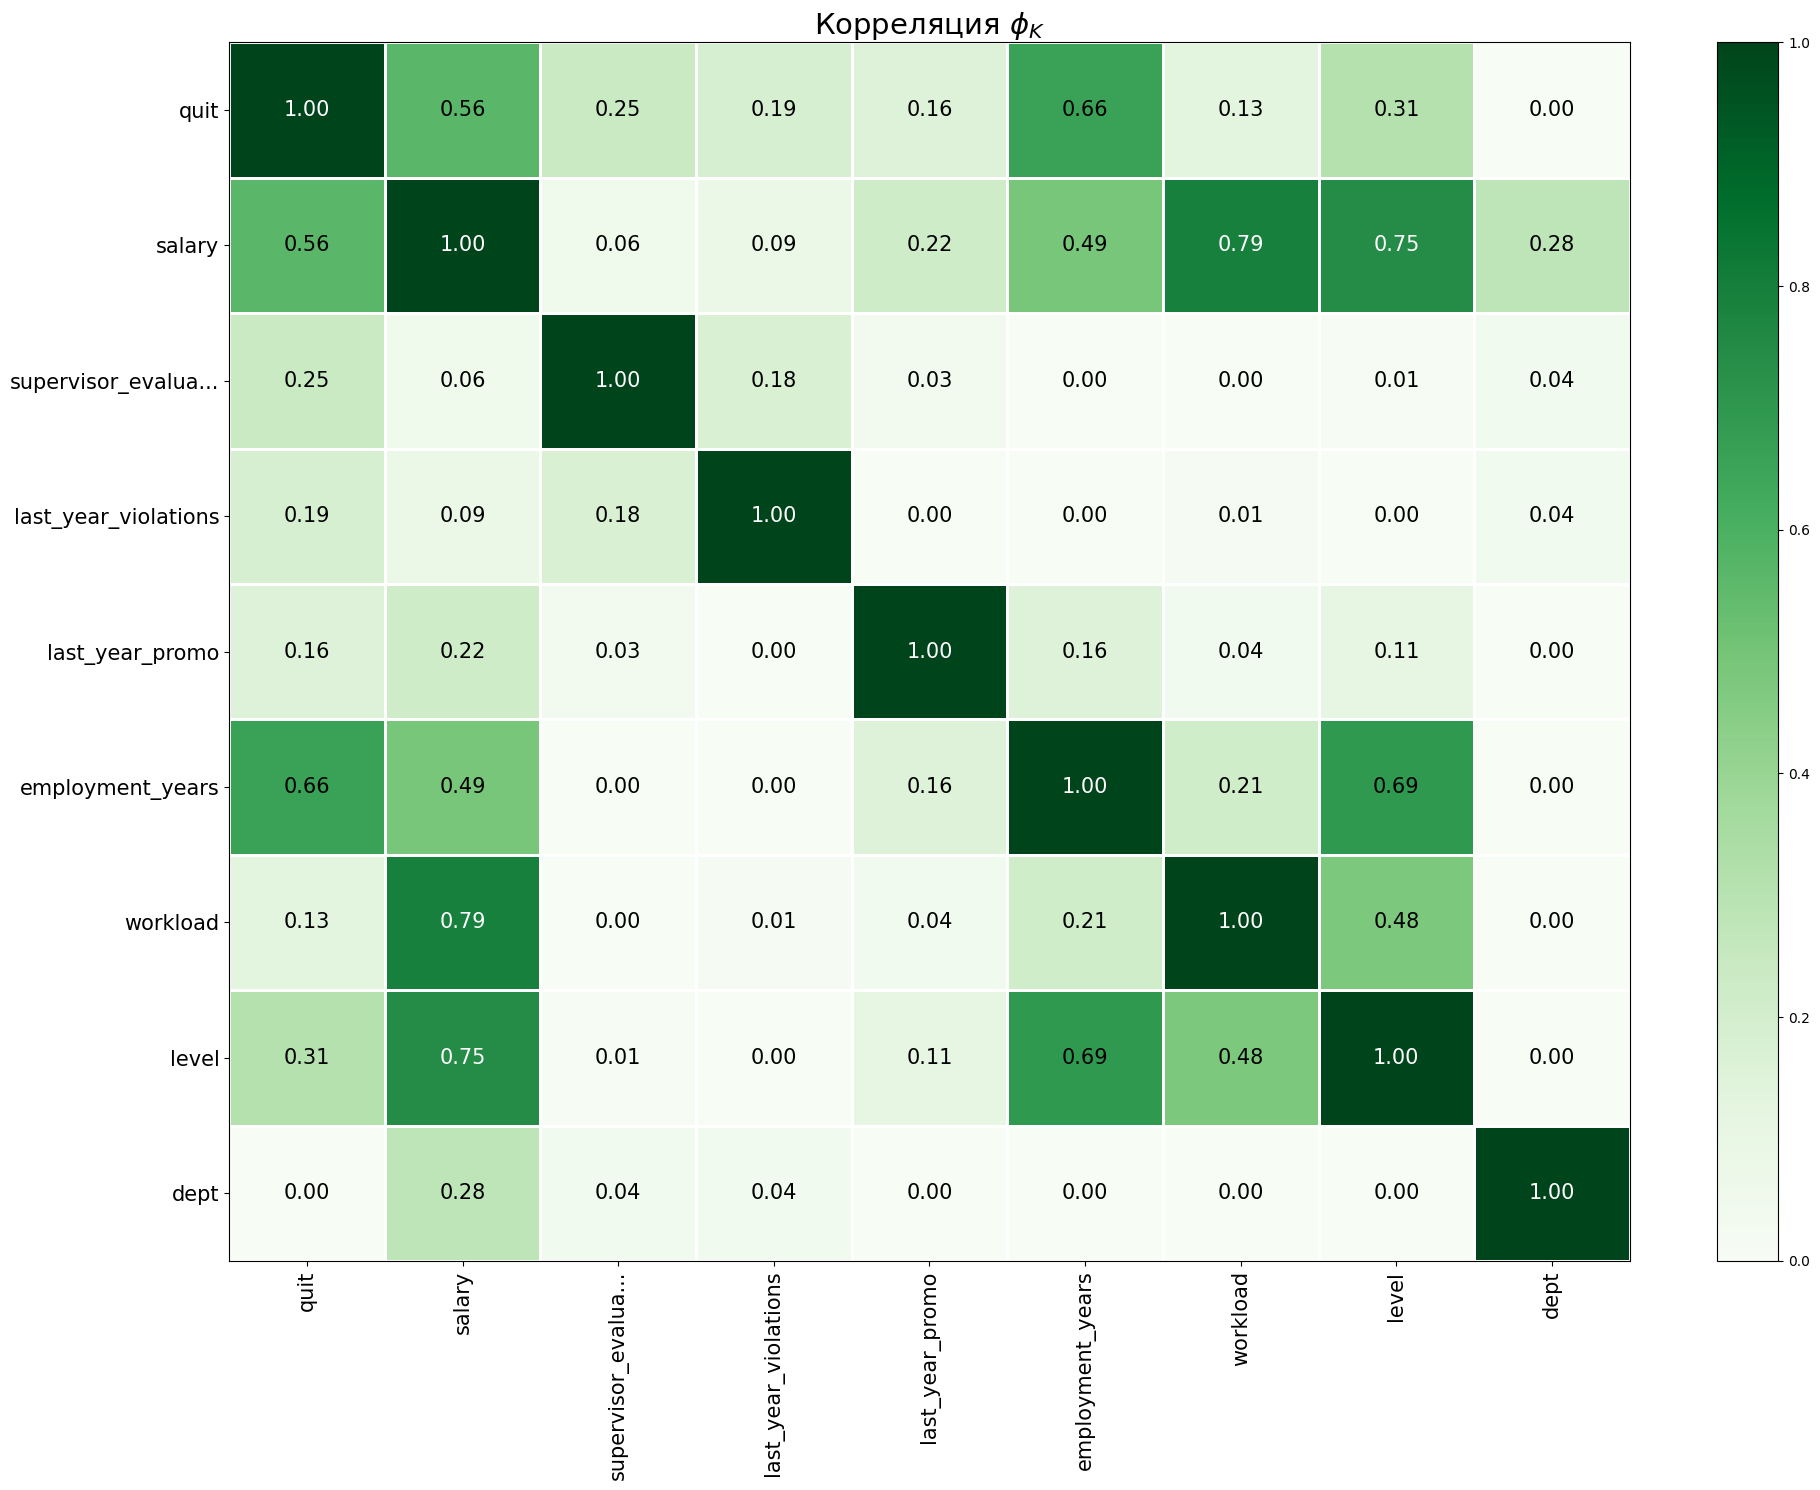

In [117]:
plot_correlation_matrix(
    phik_overview.values,
    x_labels=phik_overview.columns,
    y_labels=phik_overview.index,
    vmin=0, vmax=1, color_map='Greens',
    title=r'Корреляция $\phi_K$',
    fontsize_factor=1.5,
    figsize=(20, 15)
) 

Видим, что у целевого признака «quit» имеется умеренная (от 0.5 до 0.7) корреляция  с признаком  «employment_years» (длительность работы в компании (в годах)) и «salary» (ежемесячная зарплата сотрудника).
С остальными признаками зависимость либо слабая, либо ее вообще нет.

Сильной (выше 0.9) мультиколлинеарности между признаками нет.

Посмотрим на матрицу корреляции на тестовой выборке

In [118]:
interval_cols = ['salary']

phik_overview = phik_matrix(data_test_features \
                                .assign(quit=data_test_target_quit['quit']) \
                                .drop('id', axis=1), interval_cols=interval_cols) 

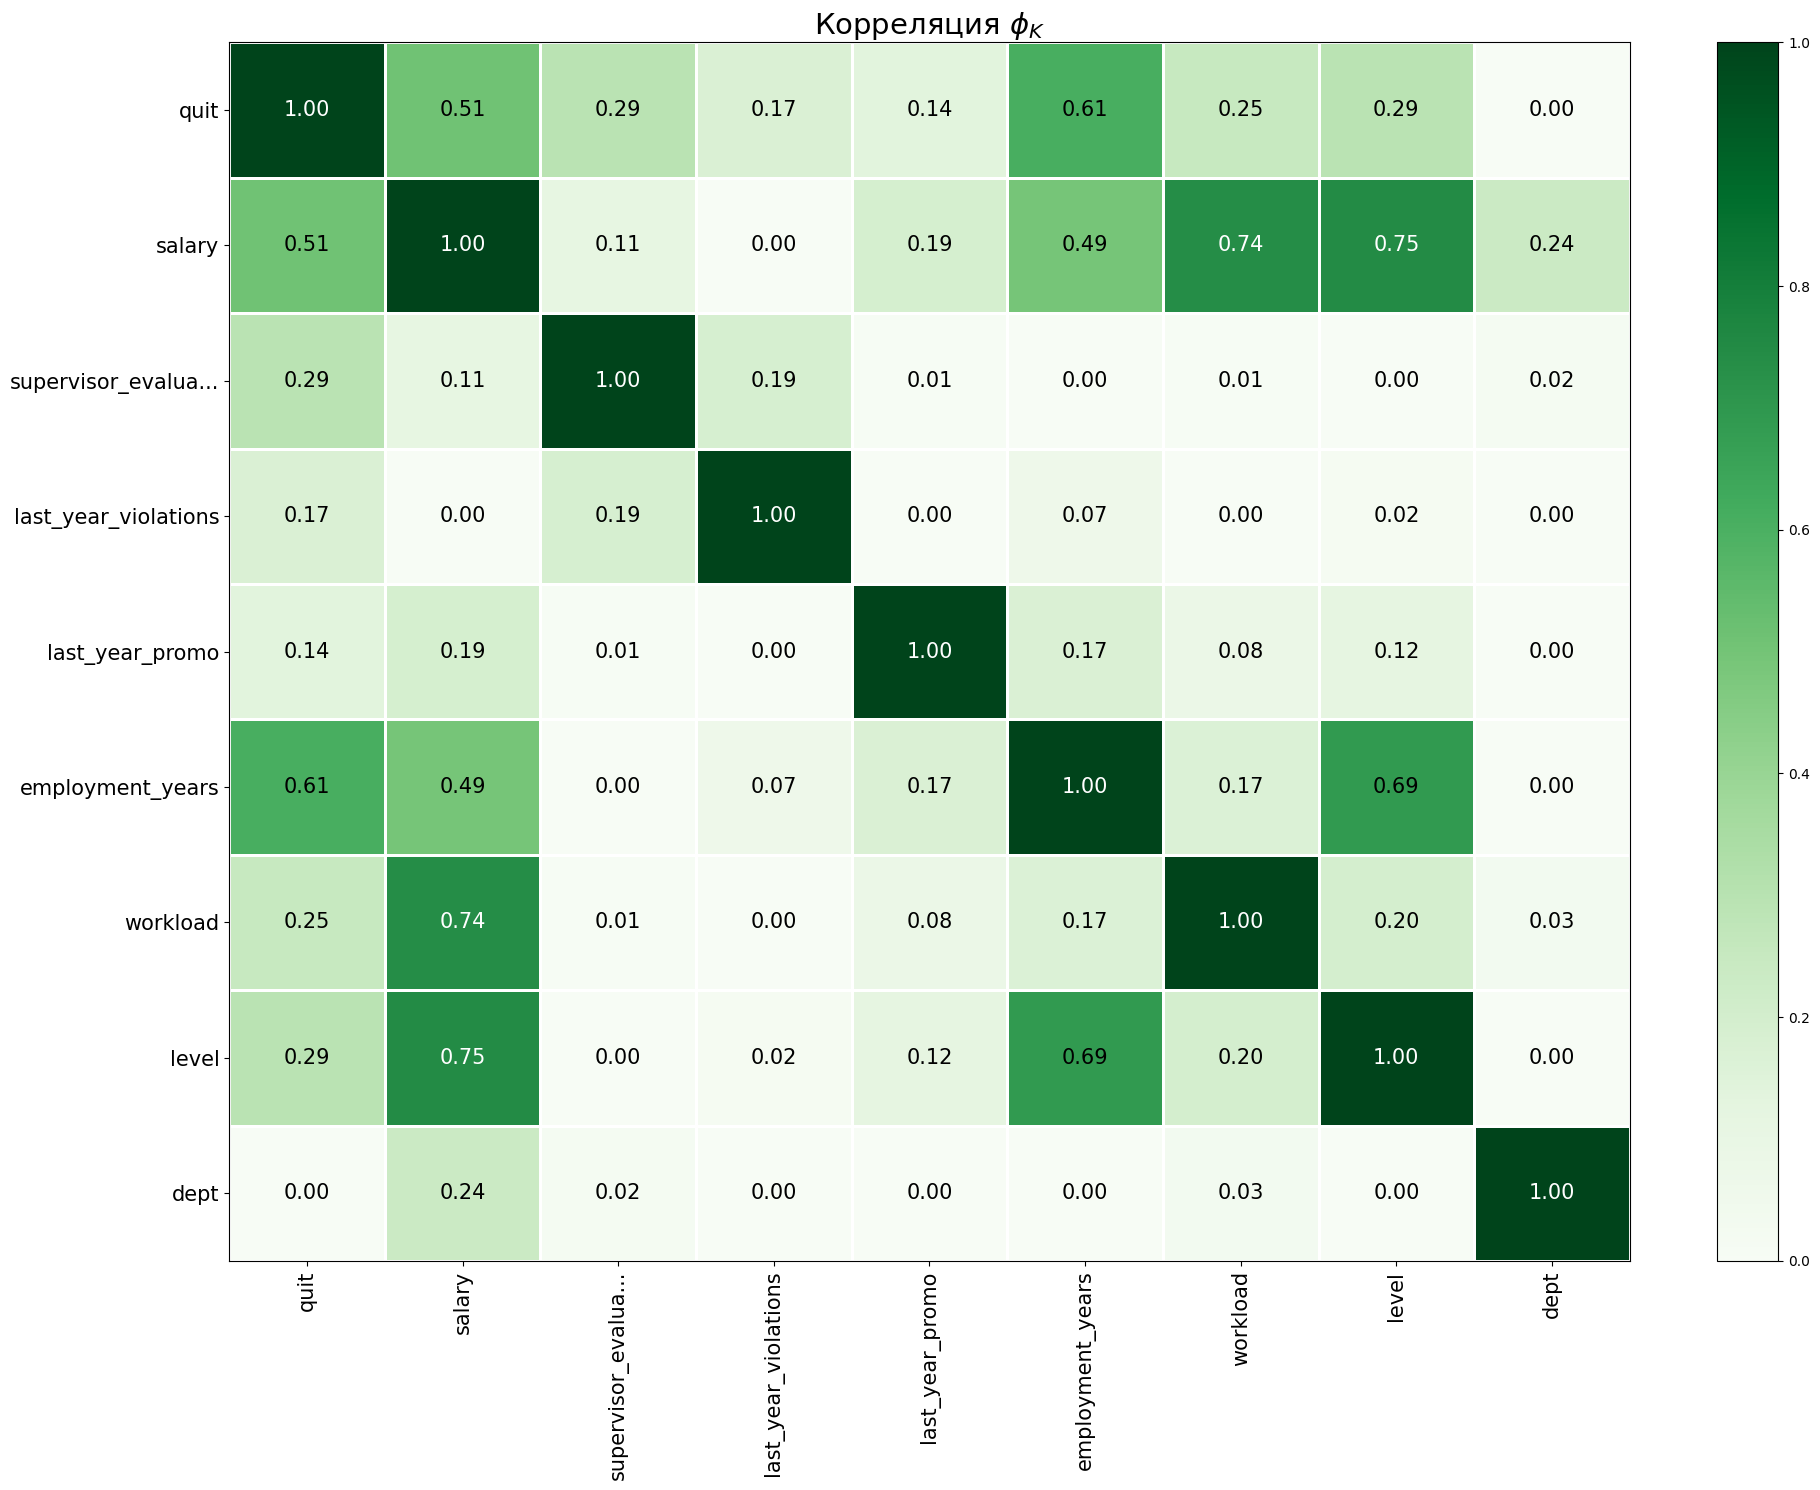

In [119]:
plot_correlation_matrix(
    phik_overview.values,
    x_labels=phik_overview.columns,
    y_labels=phik_overview.index,
    vmin=0, vmax=1, color_map='Greens',
    title=r'Корреляция $\phi_K$',
    fontsize_factor=1.5,
    figsize=(20, 15)
) 

Видим, что у целевого признака «quit» имеется умеренная (от 0.5 до 0.7) корреляция с признаком  employment_years (длительность работы в компании (в годах)), а также — «salary» (ежемесячная зарплата сотрудника).
С остальными признаками зависимость либо слабая, либо ее вообще нет.

Сильно выраженная (0.9 или выше) мультиколлинеарность между признаками в тестовой выборке также отсутствует.

В целом, в тестовой выборке между тренировочной и тестовой выборками существенных различий нет (в одном признаке отличие лишь на 1 десятую,
в остальных — в пределах сотых единиц).

#### Портрет уволившегося сотрудника

Изучим портрет уволившегося сотрудника.

Сформируем датасет из уволившихся сотрудников.

In [120]:
data_quit_employee = data_train_quit.query("quit == 'yes'")

Рассмотрим распределение уволившихся сотрудников по категориям

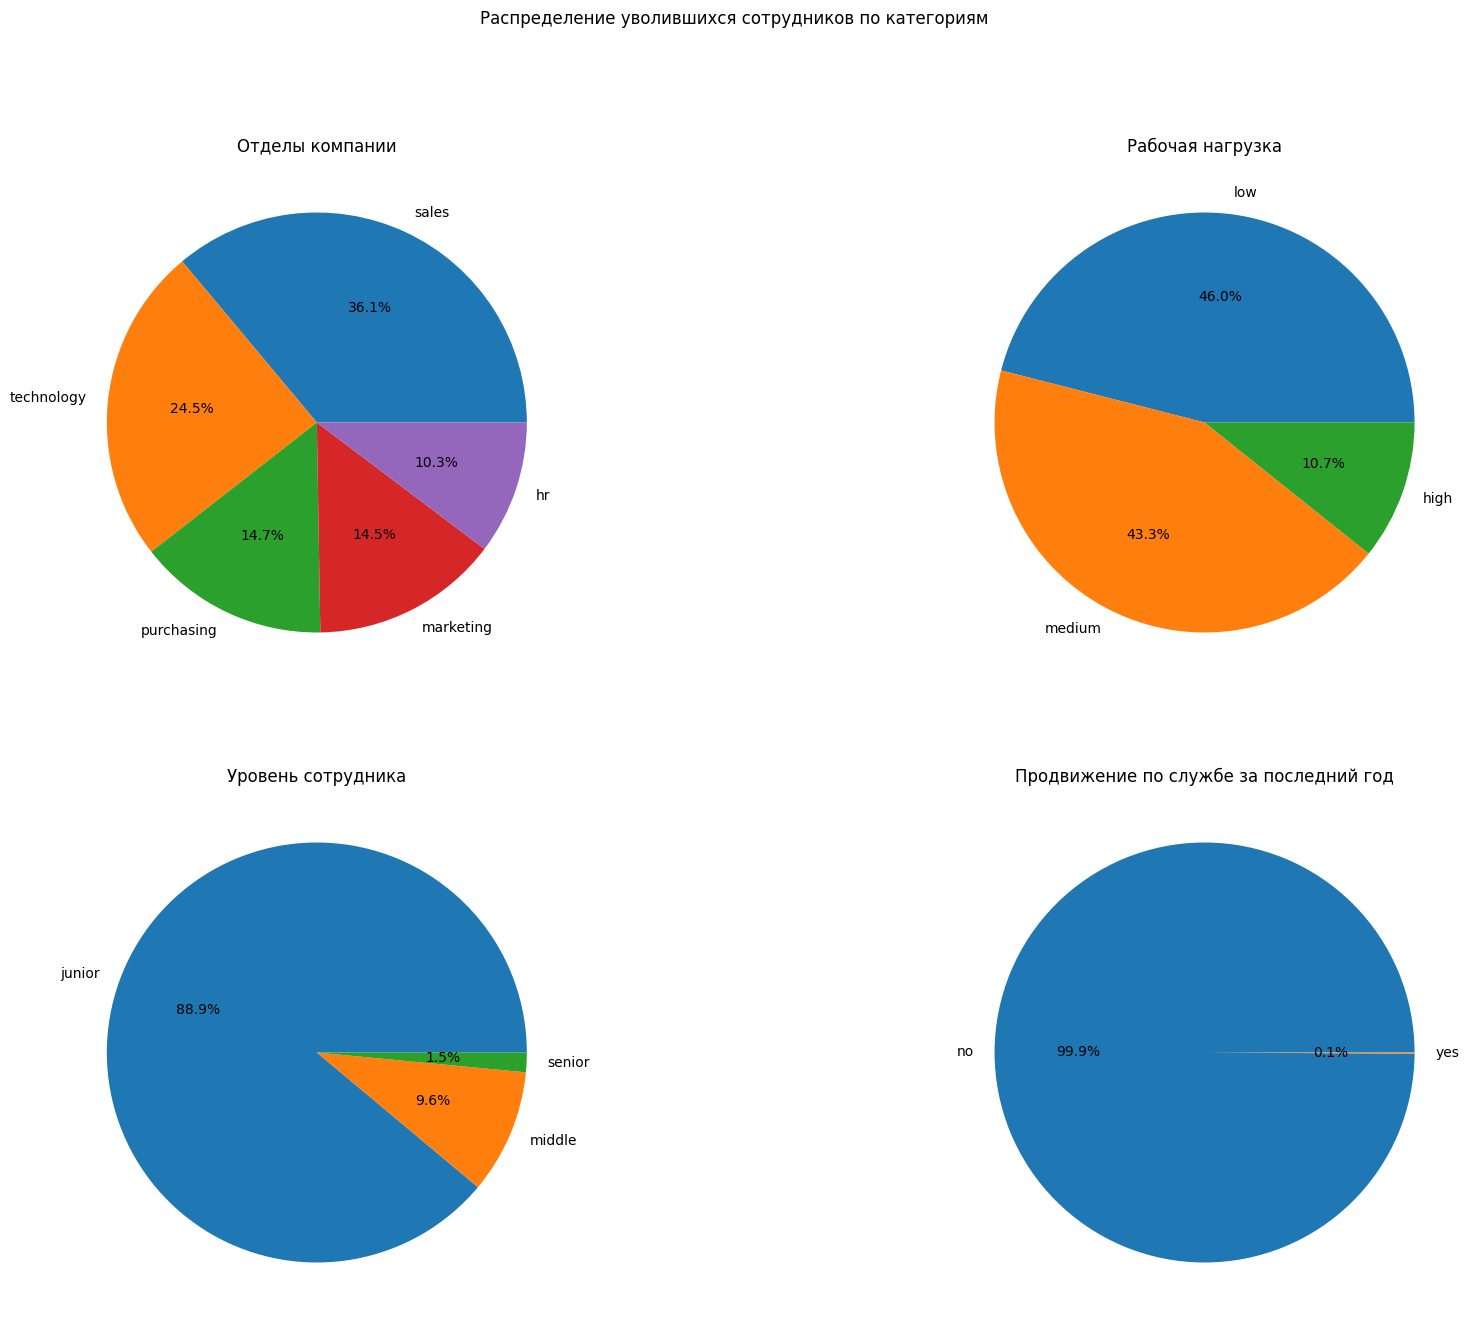

In [121]:
fig, ax = plt.subplots(2, 2, figsize=(21, 15))
fig.suptitle('Распределение уволившихся сотрудников по категориям')

data_quit_employee['dept'] \
    .value_counts() \
    .plot(ax=ax[0][0], kind='pie', ylabel='', title='Отделы компании', autopct='%1.1f%%');

data_quit_employee['workload'] \
    .value_counts() \
    .plot(ax=ax[0][1], kind='pie', ylabel='', title='Рабочая нагрузка', autopct='%1.1f%%');

data_quit_employee['level'] \
    .value_counts() \
    .plot(ax=ax[1][0], kind='pie', ylabel='', title='Уровень сотрудника', autopct='%1.1f%%');

data_quit_employee['last_year_promo'] \
    .value_counts() \
    .plot(ax=ax[1][1], kind='pie', ylabel='', title='Продвижение по службе за последний год', autopct='%1.1f%%');

Мы видим, что портрет уволившегося сотрудника по отделам в целом соответствует общей картине с минимальными изменениями.
Какого-то перекоса в пользу одного из отделов (относительно общей картины, изложенной в предыдущем разделе) мы не видим.

Подавляющее большинство уволившихся сотрудников — младшие специалисты с низкой и средней нагрузкой без продвижений по службе.

Посмотрим нарушение трудового договора за последний год

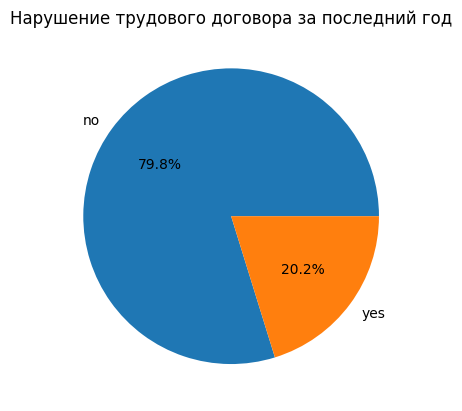

In [122]:
data_quit_employee['last_year_violations'] \
    .value_counts() \
    .plot(kind='pie', ylabel='', title='Нарушение трудового договора за последний год', autopct='%1.1f%%');

Уволившиеся сотрудники чуть чаще нарушали трудовой договор, чем в среднем по компании.

Посмотрим на распределение длительности работы в компании уволившихся и оставшихся сотрудников

In [123]:
data_stay_employee = data_train_quit.query("quit == 'no'")

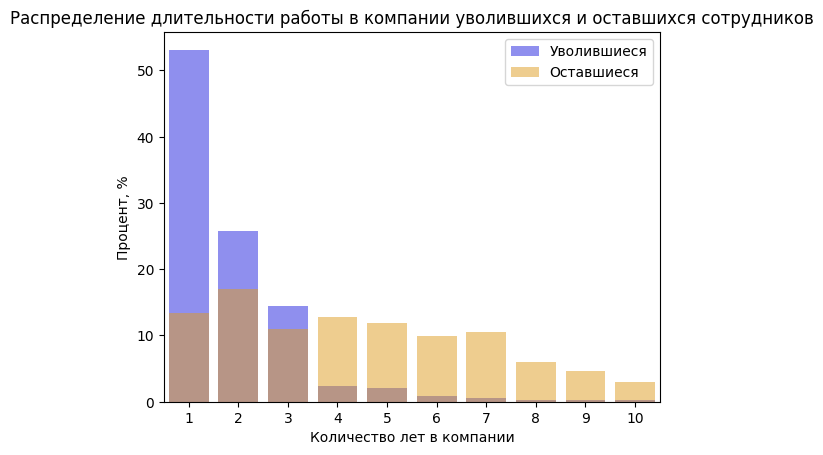

In [124]:
employment_years_vc_normed_quit = data_quit_employee['employment_years'].value_counts(normalize=True).sort_index()*100
employment_years_vc_normed_stay = data_stay_employee['employment_years'].value_counts(normalize=True).sort_index()*100

sns.barplot(data=employment_years_vc_normed_quit, color='blue', alpha=0.5, label='Уволившиеся')
sns.barplot(data=employment_years_vc_normed_stay, color='orange', alpha=0.5, label='Оставшиеся')

plt.title('Распределение длительности работы в компании уволившихся и оставшихся сотрудников')
plt.xlabel('Количество лет в компании')
plt.ylabel('Процент, %')
plt.legend()

plt.show()

Профили распределения, как мы видим, разные.
Абсолютное большинство уволившихся проработало в компании не более 3х лет (больше всего из них и в целом проработало лишь год).
Далее идет резкий спад.

Посмотрим на распределение оценок качества работы сотрудника среди уволившихся и оставшихся, которую дал руководитель

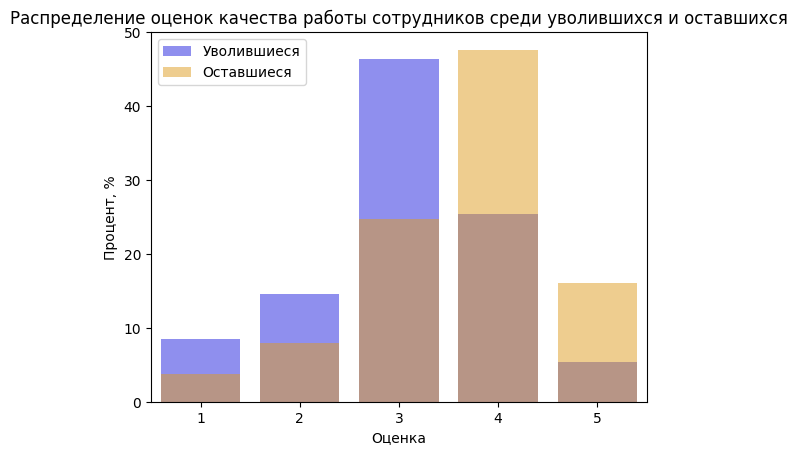

In [125]:
supervisor_eval_vc_normed_quit = data_quit_employee['supervisor_evaluation'].value_counts(normalize=True).sort_index()*100
supervisor_eval_vc_normed_stay = data_stay_employee['supervisor_evaluation'].value_counts(normalize=True).sort_index()*100

sns.barplot(data=supervisor_eval_vc_normed_quit, color='blue', alpha=0.5, label='Уволившиеся')
sns.barplot(data=supervisor_eval_vc_normed_stay, color='orange', alpha=0.5, label='Оставшиеся')

plt.title('Распределение оценок качества работы сотрудников среди уволившихся и оставшихся')
plt.xlabel('Оценка')
plt.ylabel('Процент, %')
plt.legend()

plt.show()

Видим, что профиль также немного другой.
У большинства уволившихся оценки «удовлетворительно» или ниже (т.е. с точки зрения руководителя работают, в лучшем случае, кое-как).
У большинства оставшихся мы видим, что преобладают оценки «хорошо» и «отлично». 

Рассмотрим диаграммы размаха зарплат сотрудников

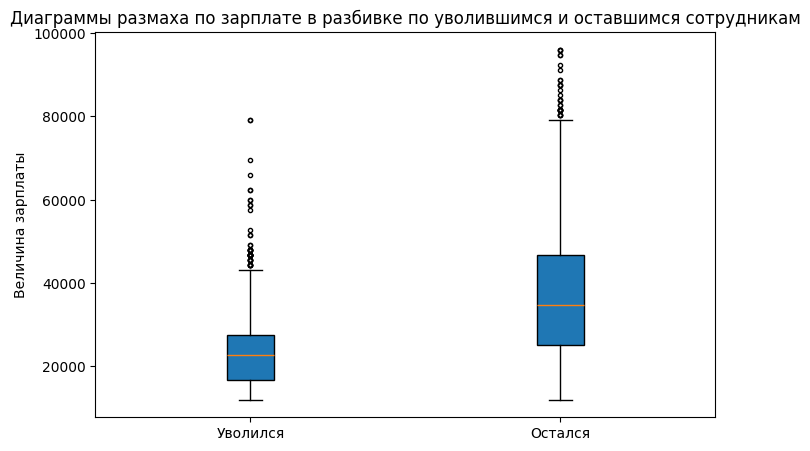

In [126]:
data_salary_employee = {}

data_salary_employee['Уволился'] = data_quit_employee['salary']
data_salary_employee['Остался'] = data_stay_employee['salary']

fig, ax = plt.subplots(figsize=(8, 5))
ax.boxplot(data_salary_employee.values(), sym='.', patch_artist=True)
ax.set_xticklabels(data_salary_employee.keys())
ax.set_title('Диаграммы размаха по зарплате в разбивке по уволившимся и оставшимся сотрудникам')
ax.set_xlabel('')
ax.set_ylabel('Величина зарплаты')
plt.show()

Уровень заработной платы у уволившихся и оставшихся сотрудников сильно различается.
Практически у $75\%$ уволившихся сотрудников зарплата ниже зарплаты почти что $75\%$ сотрудников, решивших остаться в компании.

Посмотрим и сравним уровень средней зарплаты среди уволившихся и оставшихся.

In [127]:
print("Уровень средней зарплаты уволившегося сотрудника —", data_quit_employee['salary'].mean())
print("Уровень средней зарплаты оставшегося сотрудника —", data_stay_employee['salary'].mean())

Уровень средней зарплаты уволившегося сотрудника — 23885.106382978724
Уровень средней зарплаты оставшегося сотрудника — 37702.22841225627


Мы видим, что средний уровень заработной платы у уволившихся сотрудников значительно меньше (почти на 14 тыс. руб.!), нежели у оставшихся.

##### Вывод

В целом, портрет уволившегося сотрудника можно описать следующим образом:
это младший специалист с низкой/средней нагрузкой, проработавший в компании, по крайней мере, не более 3х лет (чаще — всего год),
без продвижений на службе и низкой зарплатой.

Эти люди не видят перспектив для себя в данной компании, т.к. из-за небольшой нагрузки не могут полноценно себя реализовать с точки
зрения карьеры (как в данной компании, так и удовлетворить свои амбиции в рамках своей профессии), что усугляется низкой зарплатой и
мотивацией, поэтому вверенные им дела они выполняют кое-как.
Поэтому они активно ищут новое место работы.

#### Влияние уровня удовлетворенности сотрудника на увольнение

Для исследования влияния уровня удовлетворенности сотрудника на увольнение используем данные тестовой выборки с обоими
целевыми признаками.

In [128]:
temp_data = data_test_features.assign(job_satisfaction_rate = y_pred_first_task, quit = data_test_target_quit['quit'])

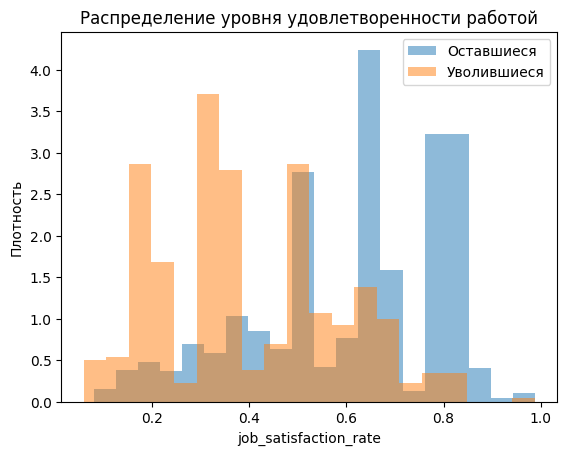

In [129]:
plt.hist(temp_data[temp_data['quit'] == 'no']['job_satisfaction_rate'], 20,  alpha=0.5, label='Оставшиеся', density=True)
plt.hist(temp_data[temp_data['quit'] == 'yes']['job_satisfaction_rate'], 20, alpha=0.5, label='Уволившиеся', density=True)
plt.legend(loc='upper right')
plt.title('Распределение уровня удовлетворенности работой')
plt.xlabel('job_satisfaction_rate')
plt.ylabel('Плотность')
plt.show()

Мы видим, что профиль распределения удовлетворенности у уволившихся отличается от такового оставшихся сотрудников.
Уровень недовольства (значения показателя удовлетворенности ниже 0.5), в среднем, явно выше, нежели у оставшихся.

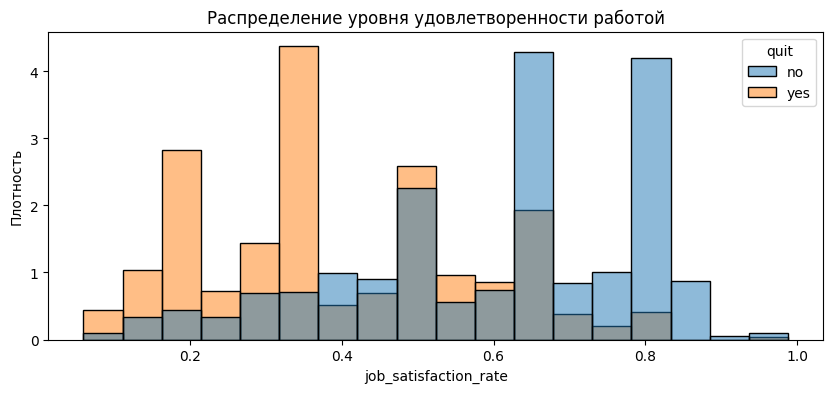

In [130]:
plt.figure(figsize=(10, 4))
sns.histplot(data=temp_data, 
             x="job_satisfaction_rate",  
             hue="quit",
             stat='density',
             common_norm=False).set(title='Распределение уровня удовлетворенности работой');
plt.ylabel('Плотность')

plt.show()

Мы видим, что профиль распределения удовлетворенности у уволившихся отличается от такового среди оставшихся сотрудников.
Уровень недовольства (значения показателя удовлетворенности ниже 0.5), в среднем, явно выше, нежели у оставшихся.

### Добавление нового входного признака

Добавим предсказанные значения признака «job_satisfaction_rate» в наш тренировочный и тестовый датасет.

In [131]:
data_train_quit = data_train_quit.assign(job_satisfaction_rate = grid.predict(data_train_quit))

In [132]:
data_test_features = data_test_features.assign(job_satisfaction_rate = y_pred_first_task)

### Подготовка данных

Т.к. тренировочные и тестовые данные уже даны по условию, то разбиение не требуется.

In [133]:
X_train = data_train_quit.drop(['id', 'quit'], axis=1)

In [134]:
y_train = data_train_quit['quit']

In [135]:
X_test = data_test_features.drop(['id'], axis=1)

In [136]:
y_test = data_test_target_quit['quit']

Закодируем целевой признак с помощью LabelEncoder.

In [137]:
le = LabelEncoder()

y_train = le.fit_transform(y_train)
y_test = le.transform(y_test)

Проверяем классы

In [138]:
le.classes_

array(['no', 'yes'], dtype=object)

Все верно: класс 'no' — 0, 'yes' — 1.

Создадим списки с признаками:

In [139]:
feature_cat_cols = ['dept', 'last_year_promo', 'last_year_violations']
feature_ord_cols = ['level', 'workload']
feature_num_cols = ['employment_years', 'salary', 'job_satisfaction_rate', 'supervisor_evaluation']

Создадим пайплайн для подготовки категориальных признаков: заполнение пропусков и прямое кодирование

In [140]:
cat_cols_pipe = Pipeline(
    [
        ('simpleImputer_ohe', SimpleImputer(missing_values=np.nan, strategy='most_frequent')),
        ('simpleImputer_ohe_2', SimpleImputer(missing_values=' ', strategy='most_frequent')),
        ('ohe', OneHotEncoder(drop='first', handle_unknown='ignore', sparse_output=False))
    ]
)

Создадим пайплайн для подготовки порядковых признаков: заполнение пропусков и порядковое кодирование

In [141]:
cat_ord_pipe = Pipeline(
    [('simpleImputer_before_ord', SimpleImputer(missing_values=np.nan, strategy='most_frequent')),
     ('ord',  OrdinalEncoder(
                categories=[
                    ['junior', 'middle', 'senior'], 
                    ['low', 'medium', 'high']
                ], 
                handle_unknown='use_encoded_value', unknown_value=np.nan
            )
        ),
     ('simpleImputer_after_ord', SimpleImputer(missing_values=np.nan, strategy='most_frequent'))
    ]
)

Создадим общий пайплайн для подготовки данных

In [142]:
data_preprocessor = ColumnTransformer(
    [('ohe', cat_cols_pipe, feature_cat_cols),
     ('ord', cat_ord_pipe, feature_ord_cols),
     ('num', MinMaxScaler(), feature_num_cols)
    ], 
    remainder='passthrough'
)

### Обучение моделей

Создаем окончательный пайплайн

In [143]:
pipe_final = Pipeline([
    ('preprocessor', data_preprocessor),
    ('models', DecisionTreeClassifier(random_state=RANDOM_STATE))
])

Словари для моделей

In [144]:
param_grid = [
    {
        'models': [DecisionTreeClassifier(random_state=RANDOM_STATE)],
        'models__min_samples_split': range(2, 10),
        'models__min_samples_leaf': range(1, 10),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']  
    },
    
    {
         'models': [KNeighborsClassifier()],
         'models__n_neighbors': range(2, 5),
         'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']   
    },

    {
         'models': [LogisticRegression(
             random_state=RANDOM_STATE, 
             solver='liblinear', 
             penalty='l1'
         )],
         'models__C': range(1, 10),
         'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']  
    }
]

Запускаем автоматический подбор модели.

In [145]:
grid_search = GridSearchCV(
    pipe_final, 
    param_grid, 
    cv=5,
    scoring='roc_auc',
    n_jobs=-1
)

In [146]:
grid_search.fit(X_train, y_train);

In [147]:
print(grid_search.best_estimator_)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ohe',
                                                  Pipeline(steps=[('simpleImputer_ohe',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('simpleImputer_ohe_2',
                                                                   SimpleImputer(missing_values=' ',
                                                                                 strategy='most_frequent')),
                                                                  ('ohe',
                                                                   OneHotEncoder(drop='first',
                                                                                 handle_unknown='ignore',
                                                                              

Значение метрики на кросс-валидации

In [148]:
print(grid_search.best_score_)

0.9242386714744957


Посмотрим значение метрики на тестовой выборке

In [149]:
roc_auc_score(y_test, grid_search.predict_proba(X_test)[:, 1])

np.float64(0.9216623204725498)

Целевое значение метрики ROC_AUC (0.91) на тестовой выборке достигнуто!

Обученные модели (десятка лучших):

In [150]:
result = pd.DataFrame(grid_search.cv_results_)
result[['rank_test_score', 'param_models', 'mean_test_score','params']].sort_values('rank_test_score').head(10)

,rank_test_score,param_models,mean_test_score,params
192,1,DecisionTreeClassifier(random_state=12345),0.924239,"{'models': DecisionTreeClassifier(random_state=12345), 'models__min_samples_leaf': 9, 'models__min_samples_split': 2, 'preprocessor__num': StandardScaler()}"
195,1,DecisionTreeClassifier(random_state=12345),0.924239,"{'models': DecisionTreeClassifier(random_state=12345), 'models__min_samples_leaf': 9, 'models__min_samples_split': 3, 'preprocessor__num': StandardScaler()}"
198,1,DecisionTreeClassifier(random_state=12345),0.924239,"{'models': DecisionTreeClassifier(random_state=12345), 'models__min_samples_leaf': 9, 'models__min_samples_split': 4, 'preprocessor__num': StandardScaler()}"
201,1,DecisionTreeClassifier(random_state=12345),0.924239,"{'models': DecisionTreeClassifier(random_state=12345), 'models__min_samples_leaf': 9, 'models__min_samples_split': 5, 'preprocessor__num': StandardScaler()}"
204,1,DecisionTreeClassifier(random_state=12345),0.924239,"{'models': DecisionTreeClassifier(random_state=12345), 'models__min_samples_leaf': 9, 'models__min_samples_split': 6, 'preprocessor__num': StandardScaler()}"
207,1,DecisionTreeClassifier(random_state=12345),0.924239,"{'models': DecisionTreeClassifier(random_state=12345), 'models__min_samples_leaf': 9, 'models__min_samples_split': 7, 'preprocessor__num': StandardScaler()}"
213,1,DecisionTreeClassifier(random_state=12345),0.924239,"{'models': DecisionTreeClassifier(random_state=12345), 'models__min_samples_leaf': 9, 'models__min_samples_split': 9, 'preprocessor__num': StandardScaler()}"
210,1,DecisionTreeClassifier(random_state=12345),0.924239,"{'models': DecisionTreeClassifier(random_state=12345), 'models__min_samples_leaf': 9, 'models__min_samples_split': 8, 'preprocessor__num': StandardScaler()}"
206,9,DecisionTreeClassifier(random_state=12345),0.924207,"{'models': DecisionTreeClassifier(random_state=12345), 'models__min_samples_leaf': 9, 'models__min_samples_split': 6, 'preprocessor__num': 'passthrough'}"
203,9,DecisionTreeClassifier(random_state=12345),0.924207,"{'models': DecisionTreeClassifier(random_state=12345), 'models__min_samples_leaf': 9, 'models__min_samples_split': 5, 'preprocessor__num': 'passthrough'}"


Итак, мы обучили три модели: логистическую регрессию, дерево решений и k ближайших соседей.
В качестве метрики была использована метрика ROC_AUC.
В итоге, лучшей оказалась модель дерева решений со следующими параметрами.

In [151]:
result.sort_values('rank_test_score')['params'].iloc[0:1].item()

{'models': DecisionTreeClassifier(random_state=12345),
 'models__min_samples_leaf': 9,
 'models__min_samples_split': 2,
 'preprocessor__num': StandardScaler()}

* Минимальное количество объектов для разделения — 2
* Минимальное количество объектов на листе — 9

Мы видим, что среди представленных моделей лучше всего себя продемонстрировало дерево решений, т.к. оно хорошо работает в ситуации,
когда в данных больше категориальных признаков, чем количественных. оно хорошо справляется с плохо сбалансированными 
данными, а также способно улавливать нелинейные зависимости.

## Вывод

HR-аналитики компании «Работа с заботой» помогают бизнесу оптимизировать управление персоналом: бизнес предоставляет данные, а аналитики предлагают, как избежать финансовых потерь и оттока сотрудников.
Бизнесу важна удовлетворённость сотрудников работой, т.к. это напрямую влияет на их отток из компании.
А предсказание оттока — одна из важнейших задач HR-аналитиков, поскольку внезапные увольнения несут в себе риски для компании,
особенно если уходит важный сотрудник.

#### Постановка задачи

Перед нами стоят две задачи:
* построить модель, которая сможет предсказать уровень удовлетворённости сотрудника на основе данных заказчика
* построить модель, которая сможет на основе данных заказчика предсказать то, что сотрудник уволится из компании.

#### Описание данных

Данные представляют собой результаты анкетирования, в ходе которого сотрудники заполняли тест-опросник и по его результатам рассчитывается
доля их удовлетворенности от 0 до 1, где 0 — совершенно неудовлетворен, 1 — полностью удовлетворен.

Для первой задачи мы имеем три датасета:
* train_job_satisfaction_rate.csv — тренировочнвя выборка
* test_features.csv — входные признаки тестовой выборки
* test_target_job_satisfaction_rate.csv — целевой признак тестовой выборки

Для второй задачи мы также имеем три датасета:
Для этой задачи можно использовать те же входные признаки, что и в первой задаче.
Однако целевой признак отличается, теперь это — увольнение сотрудника из компании.
* train_quit.csv — тренировочная выборка
* test_features.csv — входные признаки тестовой выборки (те же, что и в прошлой задаче)
* test_target_quit.csv — целевой признак тестовой выборки

#### Анализ данных

На этапе предобработки мы столкнулись со следующими проблемами:
* Были отмечены пропуски двух типов в представленных данных: NaN и символ 'пробел'.
  В первом случае, NaN решено было заменить самым частовстречающимся значением, а пробел — проигнорировать.
* Было обнаружено несоответствие id данных признакового датасета и тестового.
  Несоответствие было устрнено.

Был выполнен исследовательский анализ данных, в ходе которого были проверены выбросы и аномальные значения в данных,
изучены и проанализированы распределения признаков, был сформирован портрет уволенного сотрудника компании, а также исследовано влияние
уровня удовлетворенности работой сотрудника на увольнение.

В рамках первой части проекта для решения задачи предсказания уровня удовлетворенности сотрудника было обучено две модели: линейная регрессия и 
дерево решений. В качестве метрики была взята метрика SMAPE («симметричное среднее абсолютное процентное отклонение»). В итоге, лучшей оказалась модель дерева решений, т.к. она лучше улавливает нелинейные связи (модель линейной регрессии хорошо работает, если между целевым и входными признаками есть чёткая линейная зависимость).

В рамках второй части проекта для решения задачи предсказания увольнения сотрудника было обучено три модели: логистическая регрессия,
дерево решений и k ближайших соседей. В качестве метрики была использована метрика ROC_AUC. Лучшей оказалось дерево решений, т.к. оно хорошо работает в ситуации, когда в данных больше категориальных признаков, чем количественных, оно хорошо справляется с плохо сбалансированными данными, а также способно улавливать нелинейные зависимости.

#### Рекомендации для бизнеса

По итогам анализа данных можно выработать следующие реконмандации бизнесу:
* Необходимо обратить пристальное внимание на сотрудников уровня junior и следить за их нагрузкой.
    Необходимо нанимать меньше таких сотрудников, но оставшимся увеличить заработную плату и нагрузку в совокупности с интересными для них
    проектами, чтобы у них увеличилась карьерная мотивация в рамках данной компании. Для увеличения мотивации также следует разработать
    систему поощрений с реальными возможностями продвижения по службе. Особенно следует сфокусироваться на сотрудниках со стажем работы
    менее 3х лет.
* В целом, необходимо пристально следить за текущим уровнем удовлетворенности сотрудников работой и разработать программу лояльности
  для его повышения.